___
# __**ML Section: Predicting energy consumption at an hourly frequency for San Diego Gas & Electric (SDGE) utility region**__
___
## Table of contents:

## [Introduction: Time Series Forecasting](#0)
## [1. Importing cleaned dataset](#1)
## [2. Defining Basic Functions](#2)
## [3. Simple Linear Regression models](#3)
### $\quad$ [3.1. Statsmodels](#3.1)
### $\quad$ [3.2. SkLearn Linear Regression](#3.2)
### $\quad$$\quad$$\quad$ [3.2.1 Baseline Persistent Forecast](#3.2.1)
### $\quad$ [3.3. Ridge Regression](#3.3)
### $\quad$ [3.4. Feature engineering for hourly terms](#3.4)
### $\quad$ [3.5. Elastic Net Regression](#3.5)
## [4. Random Forest Regression](#4)
## [5. Adding lags as X variables (Elastic net & RF)](#5)
## [6. Time Series Features and Models](#6)
### $\quad$ [6.1. Basic Time series structure, Stationarity, Auto Correlation](#6.1)
### $\quad$ [6.2. Handling Multiple seasonality](#6.2)
### $\quad$ [6.3. SARIMAX](#6.3)
### $\quad$ [6.4. FB Prophet](#6.4)
## [7. Regression models using Fourier terms](#7)
### $\quad$ [7.1. Elastic net](#7.1)
### $\quad$ [7.2. Random Forest](#7.2)
### $\quad$ [7.3. XGBoost](#7.3)
### $\quad$ [7.4. XGBoost + FB Prophet trend](#7.4)
## [8. Conclusion](#8)
## [9. Future work](#9)

___
___
___

# Introduction Time Series Forecasting <a name="0"></a>
______

Time series is a sequence of observations taken sequentially in time. Our aim here, as discussed in the milestone report is- 

"The developed prediction model can be utilized by the electrical utilities to effectively plan their energy generation operations and balance the demand with appropriate supply. An efficient forecast can prove very useful for the utilities in planning their day to day operations, meeting their customers’ energy demand, and avoiding excess generation of energy."

Basically we want to fit a ML model onto our energy consumption time series and use that to predict the future energy consumption. Our time series dataset has dependent variable 'SDGE' which represents the energy consumption of the SDGE region in MWH and also has independent variables such as temperature in deg F, cumulative PV installation till date in kW and holidays and since it's a time series I have added some additional time dependent features such as hour of the day, day of the week, day of the month, season, etc. We can use all these features to train our model and use it predict the future energy values. 

Any time series data has the following components: [ref link](https://machinelearningmastery.com/time-series-forecasting/)
- Level: The baseline value for the series if it were a straight line.
- Trend: The optional and often linear increasing or decreasing behavior of the series over time.
- Seasonality: The optional repeating patterns or cycles of behavior over time.
- Noise: The optional variability in the observations that cannot be explained by the model.

Another important feature of most time series is that observations close together in time tend to be correlated (serially dependent). This feature is also called as auto-correlation and forms an important aspect of the conventional time series modeling techniques like ARIMA.

Modeling a time series involves a slightly different approach than regular ML problems. [Here](https://www.datascience.com/blog/time-series-forecasting-machine-learning-differences) is a good link explaining the main differences. 

***
In this notebook I have used the basic time series models like ARIMA and FB-prophet and then have extended my approach to include linear regression, random forests and XGBoost to see whether or not these linear and non-linear approaches can model our time series accurately.

At the end I have listed all the models with their error metrics based on which we can conclude which model/s perform the best. In any time series problem it is very important to define the window of prediction beforehand. Here I have tested the models on a future window of 1-hour, 1-week and 8 months. 1-hour ahead and 1-week ahead forecasting is easier and can be done using the lagged values of the energy consumption to increase the accuracy of the forecasts. Simple models like SARIMAX, Elastic net and Random Forest regression give around 98% R2 score and 1~2% MAPE using lag variables for short term 1-hour ahead and 1-week ahead forecasts. But if we need to forecast over a long term window (more than 1 month), we will see that FB Prophet and XGBoost (with Fourier terms for seasonalities) perform very well for longer forecast windows.

I have used the following __forecasting metrics__ to measure the prediction performance of the models used: [reference](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb)

R squared: coefficient of determination (this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$  
$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$  
sklearn.metrics.r2_score  
  
Mean Absolute Error: this has the same unit of measurment as the initial series, $[0, +\infty)$  
$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$  
sklearn.metrics.mean_absolute_error  
  
Root Mean Squared Error: the most commonly used metric that gives a higher penalty to large errors and vice versa, this too has the same unit of measurment as the initial series $[0, +\infty)$      
$RMSE = \sqrt(\frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2)$  
np.sqrt(sklearn.metrics.mean_squared_error)    

Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$  
$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$  
  
def mean_absolute_percentage_error(y_true, y_pred):   
    $\quad$ return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  


Out of the 4 metrics, MAPE will be chosen to sort the models. MAPE helps us to understand the % error on the absolute value that can be expected from a model. For example, if the MAPE is 1% and the observed energy value is 4000 MW, we can say that our model on average can preidct accurately within a $+or- 40MW$ error band.  

The error metrics for all the models will be comapred to a baseline of persistent forecast wherein simply the last year values are used for the forecast (when forecasting over longer window of >1 month).

__Time series cross validation:__  
Cross-validation for time series is a bit different because time series have this temporal structure and one cannot randomly mix values in a fold while preserving this structure. With randomization, all time dependencies between observations will be lost. This is why we will have to use a more tricky approach in optimizing the model parameters such as "cross-validation on a rolling basis".

The idea is rather simple -- we train our model on a small segment of the time series from the beginning until some $t$, make predictions for the next $t+n$ steps, and calculate an error. Then, we expand our training sample to $t+n$ value, make predictions from $t+n$ until $t+2*n$, and continue moving our test segment of the time series until we hit the last available observation. As a result, we have as many folds as $n$ will fit between the initial training sample and the last observation. This can be established using the sklearn.model_selection's TimeSeriesSplit module.
[Reference](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb)
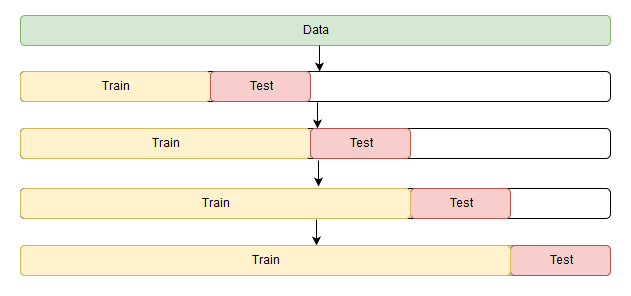

***

# 1. Importing cleaned dataset <a name="1"></a>

Importing the required libraries and modules

In [1]:
# Import basic modules
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns
from matplotlib import rcParams

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import pandas as pd

# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('bmh')

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

#sns.set_style("whitegrid")
#sns.set_context("poster")


import plotly.io as pio
pio.renderers.default = 'iframe' 

In [2]:
# Import the 5 years of hourly energy consumption data previously cleaned, explored, feature-engineered and... 
# ..stored as hourly1418_energy_temp_PV.csv

sdge = pd.read_csv('hourly1418_energy_temp_PV.csv', index_col = 'Dates', parse_dates=['Dates', 'Date'])

In [3]:
sdge.head()

,SDGE,Date,year,month,day,hour,weekday,season,holiday,non_working,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW
Dates,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,2096.0,2014-01-01,2014,1,1,0,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.0,0.0,220992.227
2014-01-01 01:00:00,1986.0,2014-01-01,2014,1,1,1,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.5,0.0,220992.227
2014-01-01 02:00:00,1936.0,2014-01-01,2014,1,1,2,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.8,0.0,220992.227
2014-01-01 03:00:00,1896.0,2014-01-01,2014,1,1,3,Wednesday,winter,1,non-working,72290023188,0.0,7.0,50.0,0.0,220992.227
2014-01-01 04:00:00,1899.0,2014-01-01,2014,1,1,4,Wednesday,winter,1,non-working,72290023188,0.0,7.0,48.8,0.0,220992.227


***
# 2. Defining Basic Functions <a name="2"></a>
***
Defining basic functions like calculating error metrics, plotting predicted vs original time series, etc. so that we can use the same functions seamlessly across different models and this will also allow us to compare different models using the same metrics. 
***

In [4]:
# Creating an empty dict to save all the erros from different models
dict_error = dict()

In [5]:
# creating function for plotting predicted vs actual energy values
def plot_predvstrue_reg(pred, truth, model_name=None):
    """
    Plots the observed energy consumption against the predicted energy consumption
    """
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.scatter(truth, pred) 
    _ = plt.xlabel("Observed energy in MWH")
    _ = plt.ylabel("Predicted energy in MWH")
    _ = plt.title("Observed vs Predicted energy using model {}".format(model_name))
    _ = plt.xlim(1000, 5000)
    _ = plt.ylim(1000, 5000)
    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    _ = ax.plot(x, x)

In [6]:
def error_metrics(y_pred, y_truth, model_name = None, test = True):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error), MAPE (mean absolute % error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    test: if validating on test set, True; otherwise False for training set validation
    
    The function will print the RMSE, R2, MAE and MAPE error metrics for the model_name and also store the results along with 
    model_name in the dictionary dict_error so that we can compare all the models at the end.
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    #df = pd.DataFrame({'model': model_name, 'RMSE':RMSE, 'R2':R2, 'MAE':MAE, 'MAPE':MAPE}, index=[0])
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    
    for error in list_error:
        if error[0] in dict_error:
            # append the new number to the existing array at this slot
            dict_error[error[0]].append(error[1])
        else:
            # create a new array in this slot
            dict_error[error[0]] = [error[1]]
    #return(dict_error)

In [7]:
def plot_timeseries(ts, title = 'og', opacity = 1):
    """
    Plot plotly time series of any given timeseries ts
    """
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = ts.index, y = ts.values, name = "observed",
                         line_color = 'lightslategrey', opacity = opacity))

    fig.update_layout(title_text = title,
                  xaxis_rangeslider_visible = True)
    fig.show()

In [8]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted energy MWH values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [9]:
def train_test(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False):
    """
    
        Perform train-test split with respect to time series structure
        
        - df: dataframe with variables X_n to train on and the dependent output y which is the column 'SDGE' in this notebook
        - test_size: size of test set
        - scale: if True, then the columns in the -'cols_to_transform'- list will be scaled using StandardScaler
        - include_test_scale: If True, the StandardScaler fits the data on the training as well as the test set; if False, then
          the StandardScaler fits only on the training set.
        
    """
    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale and include_test_scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = df.SDGE.iloc[:test_index]
    X_test = df.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = df.SDGE.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

***
# 3. Simple Linear Regression models <a name="3"></a>
***
Starting off with simple linear regression models to see how they perform on our time series dataset.


In [10]:
# creating categorical columns for linear regression 
cat_cols = ['year', 'month', 'day', 'hour', 'weekday', 'season', 'holiday', 'non_working']

for col in cat_cols:
    sdge[col] = sdge[col].astype('category')

In [11]:
sdge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2014-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SDGE                      43824 non-null  float64       
 1   Date                      43824 non-null  datetime64[ns]
 2   year                      43824 non-null  category      
 3   month                     43824 non-null  category      
 4   day                       43824 non-null  category      
 5   hour                      43824 non-null  category      
 6   weekday                   43824 non-null  category      
 7   season                    43824 non-null  category      
 8   holiday                   43824 non-null  category      
 9   non_working               43824 non-null  category      
 10  STATION                   43824 non-null  int64         
 11  DailyCoolingDegreeDays    43824 non-null  flo

In [12]:
# Preparing dummy columns for use in sklearn's linear regression 
sdge_lin = pd.get_dummies(sdge, drop_first = True)

In [13]:
sdge_lin.head(3)

,SDGE,Date,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW,year_2015,year_2016,...,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_winter,holiday_1,non_working_working
Dates,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,2096.0,2014-01-01,72290023188,0.0,7.0,51.0,0.0,220992.227,False,False,...,False,False,False,False,False,False,True,True,True,False
2014-01-01 01:00:00,1986.0,2014-01-01,72290023188,0.0,7.0,51.5,0.0,220992.227,False,False,...,False,False,False,False,False,False,True,True,True,False
2014-01-01 02:00:00,1936.0,2014-01-01,72290023188,0.0,7.0,51.8,0.0,220992.227,False,False,...,False,False,False,False,False,False,True,True,True,False


In [14]:
sdge_lin.columns

Index(['SDGE', 'Date', 'STATION', 'DailyCoolingDegreeDays',
       'DailyHeatingDegreeDays', 'HourlyDryBulbTemperature', 'AC_kW',
       'cum_AC_kW', 'year_2015', 'year_2016', 'year_2017', 'year_2018',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'week

## 3.1. Statsmodels  <a name="3.1"></a>

#### Fitting linear regression using statsmodel

There are multiple external regressor terms, in addition to the time related terms, in the dataset like 'DailyCoolingDegreeDays', 'DailyHeatingDegreeDays', 'HourlyDryBulbTemperature', 'AC_kW', 'cum_AC_kW'. In this project we'll be focusing only on the 'HourlyDryBulbTemperature' and 'cum_AC_kW' columns because 'AC_kW' data has been captured cumulatively in the 'cum_AC_kW' column and the 'DailyCoolingDegreeDays' and 'DailyHeatingDegreeDays' columns are dependent on the daily temperature, so to avoid any correlation between the X variables we will use only the temperature data.

In [15]:
# Checking linear regression fit using statsmodels Linear regression

m = ols('SDGE ~  C(year) + C(month) + C(hour) + C(season) + C(non_working) + \
                 HourlyDryBulbTemperature + cum_AC_kW', sdge).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   SDGE   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     3495.
Date:                Sun, 04 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:57:38   Log-Likelihood:            -3.0102e+05
No. Observations:               43824   AIC:                         6.021e+05
Df Residuals:                   43782   BIC:                         6.025e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#### Plotting the observed vs predicted values for the above statsmodel linear regression model

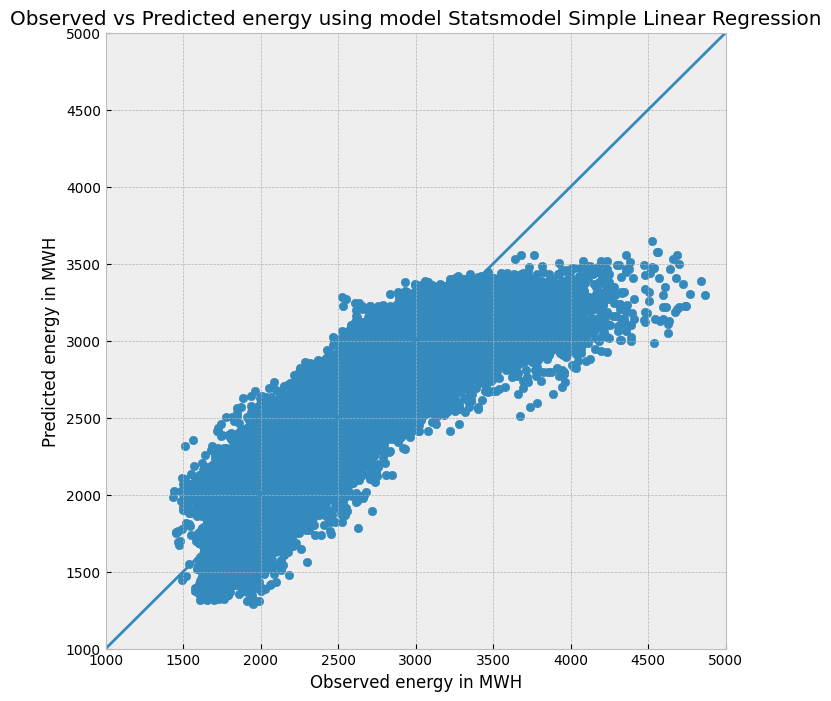

In [16]:
plot_predvstrue_reg(m.fittedvalues, sdge.SDGE, model_name = 'Statsmodel Simple Linear Regression')

* The R2 for such a simple model is surprisingly good (0.766). And we see that some of the most important variables are the hour values, season and we also see a slightly decreasing trend with years. i.e. the energy consumption slightly decreases from 2014 to 2018.
* The model predicts very well till ~3000MWH but then it fails to predict the higher energy consumption values.
* But we need to be careful before interpreting this model because the X variables weren't scaled and the model was fit on the entire dataset. We will solve these issues now in the upcoming models.

## 3.2. SkLearn Linear Regression  <a name="3.2"></a>

#### Fitting linear regression using sklearn

In [17]:
# Keeping only the necessary columns; day columns were removed because there is 0 to none monthly seasonality in the data    
sdge_lin.drop(['Date','STATION', 'AC_kW', 'DailyCoolingDegreeDays','DailyHeatingDegreeDays',           
              'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
              'weekday_Tuesday', 'weekday_Wednesday', 'holiday_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
               'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
               'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
               'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
               'day_28', 'day_29', 'day_30', 'day_31'], axis = 1, inplace = True)

In [18]:
sdge_lin.columns

Index(['SDGE', 'HourlyDryBulbTemperature', 'cum_AC_kW', 'year_2015',
       'year_2016', 'year_2017', 'year_2018', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'season_winter', 'non_working_working'],
      dtype='object')

In [19]:
# Creating the train and test data
# A test_size og 0.15 gives us a training set of 4 years and 3 months and a test set of 9 months (the test set includes 
#...winter and summer seasons.

cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW'] # other columns are binary values
X_train, X_test, y_train, y_test = train_test(sdge_lin, test_size = 0.15, scale = True, cols_to_transform=cols_to_transform)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression()

In [20]:
# Fitting the linear regression model
lm.fit(X_train, y_train)

LinearRegression()

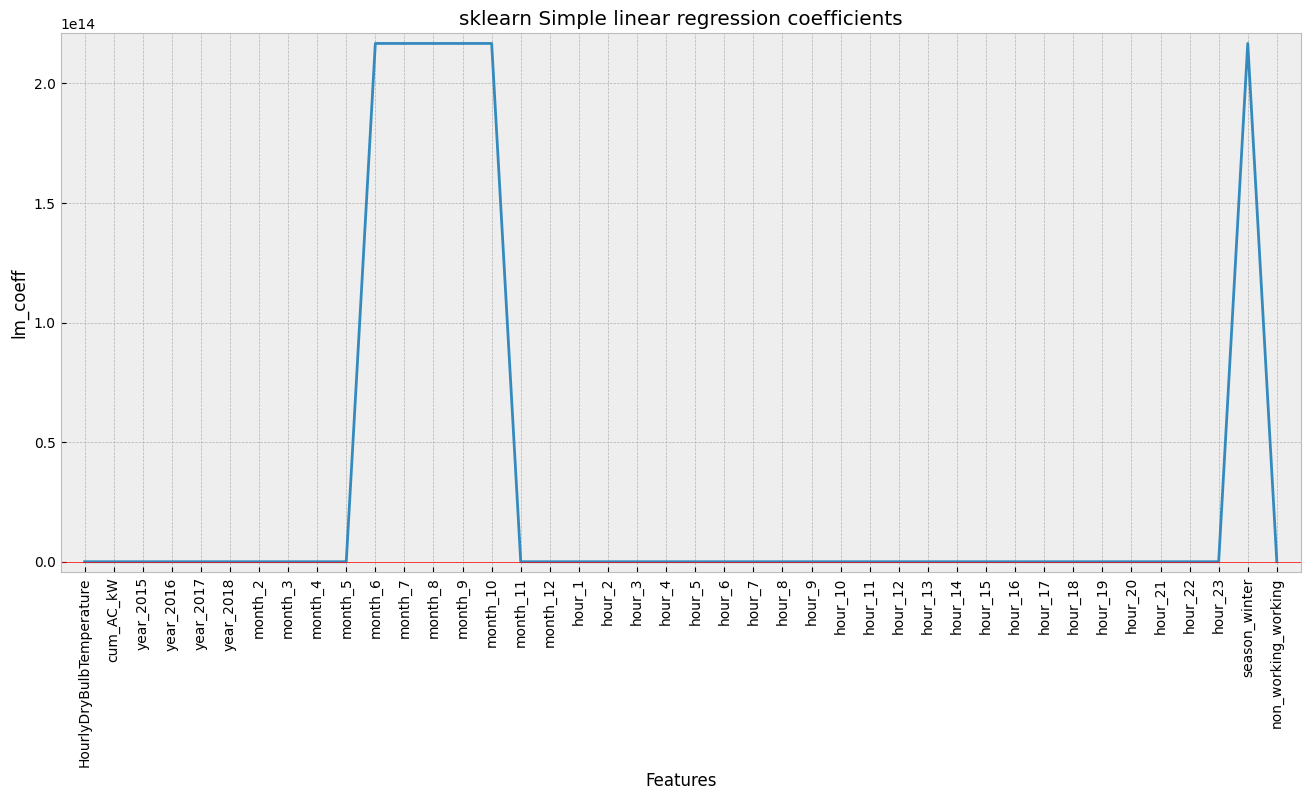

In [21]:
# Plotting the coefficients to check the importance of each coefficient 

# Plot the coefficients
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train.columns)), lm.coef_)
_ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('sklearn Simple linear regression coefficients')
_ = plt.ylabel('lm_coeff')
_ = plt.xlabel('Features')

***
* The coefficent plot basically says that the energy values increase with temperature, are higher in summer months than winter months, are higher for working days than non-working days and decrease over the years from 2014-2018. 
* The hour variable is the most significant coeffecient where the energy increases significantly over the evening hours.

In [22]:
#X_train.describe().T[['min', 'max']]

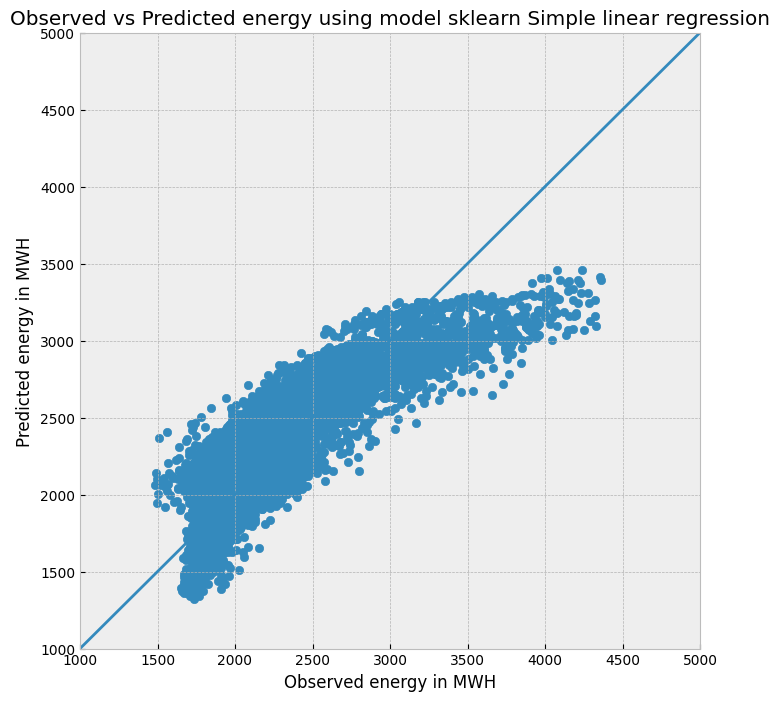

In [23]:
# Plotting lm.predict(X) vs observed energy consumption

plot_predvstrue_reg(lm.predict(X_test), y_test, model_name = 'sklearn Simple linear regression')

* We can see the model is under predicting the higher energy values.

In [24]:
error_metrics(lm.predict(X_train), y_train, model_name = 'Simple linear regression with scaling', test = False)


Error metrics for model Simple linear regression with scaling
RMSE or Root mean squared error: 230.15
Variance score: 0.77
Mean Absolute Error: 170.24
Mean Absolute Percentage Error: 7.13 %


In [25]:
# on test set
error_metrics(lm.predict(X_test), y_test, model_name = 'Simple linear regression with scaling', test = True)


Error metrics for model Simple linear regression with scaling
RMSE or Root mean squared error: 254.93
Variance score: 0.73
Mean Absolute Error: 195.01
Mean Absolute Percentage Error: 8.38 %


In [26]:
lm.predict(X_test)

array([1607.1875 , 1589.8125 , 1610.125  , ..., 2455.875  , 2215.65625,
       1976.28125])

In [27]:
# Plotting the predicted values with the original time series (test set)
plot_ts_pred(y_test, lm.predict(X_test), model_name='Simple linear regression with scaling', 
             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

* It can be seen that the model predicts the daily trend and seasonality pretty well but the high peaks are not captured by the model very well. It can be said the daily, weekly and yearly seasonalities were captured decently well by the model.
* But from the error metrics on the train and test sets it can be observed that the model is stable and isn't overfitting. 

***
### 3.2.1 Baseline Persistent Forecast <a name="3.2.1"></a>
I had mentioned in the introduction that all the models will be compared to a baseline persistent model which is simply a repetition of the last year energy consumption values.

In [28]:
# Calculating the errors for persistent forecast (where we simply repeat the values from last year)
#y_test.index.year
_ = error_metrics(sdge_lin.loc[X_test.index.shift(-8760, freq='H'), 'SDGE'], 
                  y_test, model_name='Baseline Persistent forecast, repeat last year', test=True)


Error metrics for model Baseline Persistent forecast, repeat last year
RMSE or Root mean squared error: 330.74
Variance score: 0.55
Mean Absolute Error: 224.89
Mean Absolute Percentage Error: 9.23 %


In [29]:
plot_ts_pred(y_test, sdge_lin.loc[X_test.index.shift(-8760, freq='H'), 'SDGE'].to_numpy(),
             model_name='Baseline Persistent forecast, repeat last year')

In [30]:
# In the energy forecasting domain, it is even more important to get the daily max demand right. So, calculating the ...
#...error on that too

# Resampling both the y_test and predictions at a 24 hours period and using the max as the aggregate function
_ = error_metrics(sdge_lin.loc[X_test.index.shift(-8760, freq='H'), 'SDGE'].resample('24h').max(), 
                  y_test.resample('24h').max(), 
                  model_name='Baseline Persistent forecast, repeat last year; daily MAX', test=True)


Error metrics for model Baseline Persistent forecast, repeat last year; daily MAX
RMSE or Root mean squared error: 389.37
Variance score: 0.22
Mean Absolute Error: 264.44
Mean Absolute Percentage Error: 8.60 %


In [31]:
print('error on hour ahead persistent forecast')
_ = error_metrics(sdge_lin.loc[X_test.index.shift(-1, freq='H'), 'SDGE'], 
                  y_test, model_name='Baseline Persistent forecast, repeat last hour', test=True)

error on hour ahead persistent forecast

Error metrics for model Baseline Persistent forecast, repeat last hour
RMSE or Root mean squared error: 122.27
Variance score: 0.94
Mean Absolute Error: 99.23
Mean Absolute Percentage Error: 4.21 %


In [32]:
print('error on week ahead persistent forecast')
_ = error_metrics(sdge_lin.loc[X_test.index.shift(-7, freq='H'), 'SDGE'], 
                  y_test, model_name='Baseline Persistent forecast, repeat last week', test=True)

error on week ahead persistent forecast

Error metrics for model Baseline Persistent forecast, repeat last week
RMSE or Root mean squared error: 568.36
Variance score: -0.33
Mean Absolute Error: 468.22
Mean Absolute Percentage Error: 20.27 %


## 3.3. Ridge Regression  <a name="3.3"></a>

#### Fitting Ridge regression using sklearn (L2 regularization)

* Trying linear regression with regularization using the L2 norm (Ridge regression)

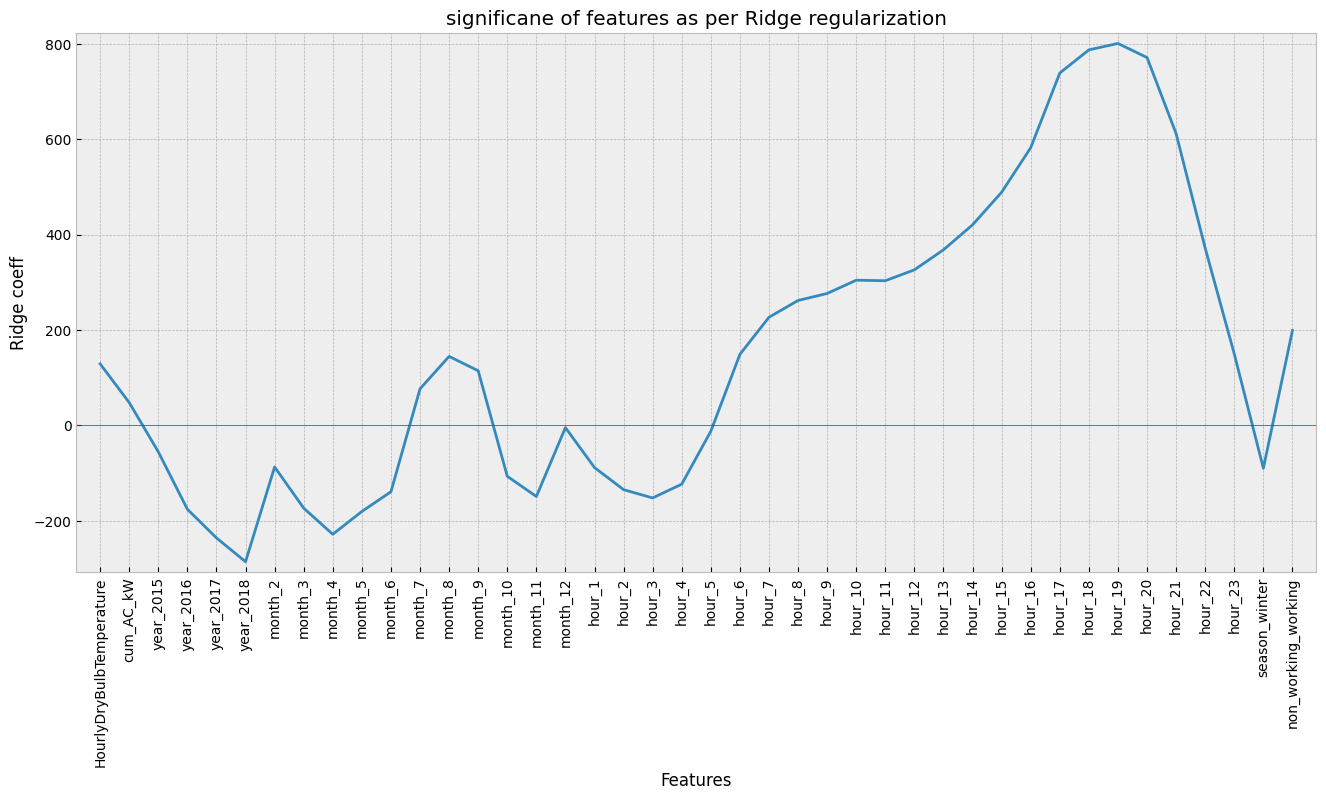

In [33]:
# Trying regularization: Ridge regression
from sklearn.linear_model import Ridge

# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha = 0.2) #selecting alpha=0.2 here. , normalize = True
# Tried different values from 0.1 to 0.8, results don't change much

# Fit the regressor to the data
ridge.fit(X_train, y_train)

# Compute and print the coefficients
ridge_coef = ridge.coef_
#print(ridge_coef)

# Plot the coefficients
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train.columns)), ridge_coef)
_ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('significane of features as per Ridge regularization')
_ = plt.ylabel('Ridge coeff')
_ = plt.xlabel('Features')
################################################################################

* The significance of features remains more or less same as observed for the simple linear regression model.

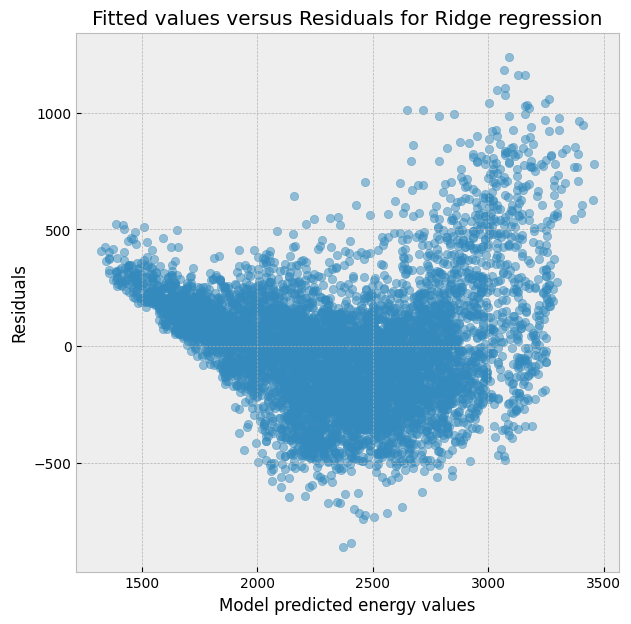

In [34]:
# PLotting the residuals
residuals = (y_test - ridge.predict(X_test))
_ = plt.figure(figsize=(7,7))
_ = plt.scatter(ridge.predict(X_test) , residuals, alpha = 0.5) 
_ = plt.xlabel("Model predicted energy values")
_ = plt.ylabel("Residuals")
_ = plt.title("Fitted values versus Residuals for Ridge regression")

In [35]:
print('Ridge regression on training set')
error_metrics(ridge.predict(X_train), y_train, model_name = 'Ridge regression with scaling', test = False)

print('\nRidge regression on test set')
error_metrics(ridge.predict(X_test), y_test, model_name = 'Ridge regression with scaling', test = True)


Ridge regression on training set

Error metrics for model Ridge regression with scaling
RMSE or Root mean squared error: 230.15
Variance score: 0.77
Mean Absolute Error: 170.18
Mean Absolute Percentage Error: 7.13 %

Ridge regression on test set

Error metrics for model Ridge regression with scaling
RMSE or Root mean squared error: 254.79
Variance score: 0.73
Mean Absolute Error: 194.78
Mean Absolute Percentage Error: 8.36 %


In [36]:
# Plotting the observed test energy and predicted energy data on the same graph as line plots

plot_ts_pred(y_test, ridge.predict(X_test), model_name='Ridge regression', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

* Thus, we can see that the ridge regression and simple regression without any regularization perform decently well on the test set and the models don't overfit capturing the overall trend and seasonality pretty well. 
* The residuals as expected are not normally distributed and are biased towards the ends because the model doesn't predict the extreme values very well, especially the high energy consumption in the summer. 

## 3.4. Reducing the feature space <a name="3.4"></a>

#### Trying different columns this time

* In the above models we had used hot encoded variables like hour_1, hour_2,..., month_2, month_3,.. etc. This results in a loss of information because the model assumes that 23rd hour is far away from the 0th hour (and same for months, month_12 is far away from month_1) which is not the case because the time series is periodic and the 0th hour is as much closer to the 23rd hour as it is to the 1st hour. To avoid the loss of information and to lower the number of predictor variables we'll try some feature engineering on the X space. 

* We'll also emit the month and weekday columns because the season column captures the months feature anyways. So the number of X variables used in the models below will be considerably lower than the above models. 

In [37]:
# Creating a new dataframe similar to the first one
sdge1 = pd.read_csv('hourly1418_energy_temp_PV.csv', index_col = 'Dates', parse_dates=['Dates', 'Date'])

In [38]:
sdge1.head()

,SDGE,Date,year,month,day,hour,weekday,season,holiday,non_working,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW
Dates,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,2096.0,2014-01-01,2014,1,1,0,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.0,0.0,220992.227
2014-01-01 01:00:00,1986.0,2014-01-01,2014,1,1,1,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.5,0.0,220992.227
2014-01-01 02:00:00,1936.0,2014-01-01,2014,1,1,2,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.8,0.0,220992.227
2014-01-01 03:00:00,1896.0,2014-01-01,2014,1,1,3,Wednesday,winter,1,non-working,72290023188,0.0,7.0,50.0,0.0,220992.227
2014-01-01 04:00:00,1899.0,2014-01-01,2014,1,1,4,Wednesday,winter,1,non-working,72290023188,0.0,7.0,48.8,0.0,220992.227


In [39]:
# Dividing the hours into 4 groups-> night, morning, afternoon, evening

hour_dict = {'morning': list(np.arange(7,13)),'afternoon': list(np.arange(13,16)), 'evening': list(np.arange(16,22)),
            'night': [22, 23, 0, 1, 2, 3, 4, 5, 6]}

In [40]:
hour_dict

{'morning': [7, 8, 9, 10, 11, 12],
 'afternoon': [13, 14, 15],
 'evening': [16, 17, 18, 19, 20, 21],
 'night': [22, 23, 0, 1, 2, 3, 4, 5, 6]}

In [41]:
def time_of_day(x):
    if x in hour_dict['morning']:
        return 'morning'
    elif x in hour_dict['afternoon']:
        return 'afternoon'
    elif x in hour_dict['evening']:
        return 'evening'
    else:
        return 'night'

In [42]:
sdge1['time_of_day'] = sdge1['hour'].apply(time_of_day)

In [43]:
sdge1.head()

,SDGE,Date,year,month,day,hour,weekday,season,holiday,non_working,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW,time_of_day
Dates,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,2096.0,2014-01-01,2014,1,1,0,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.0,0.0,220992.227,night
2014-01-01 01:00:00,1986.0,2014-01-01,2014,1,1,1,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.5,0.0,220992.227,night
2014-01-01 02:00:00,1936.0,2014-01-01,2014,1,1,2,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.8,0.0,220992.227,night
2014-01-01 03:00:00,1896.0,2014-01-01,2014,1,1,3,Wednesday,winter,1,non-working,72290023188,0.0,7.0,50.0,0.0,220992.227,night
2014-01-01 04:00:00,1899.0,2014-01-01,2014,1,1,4,Wednesday,winter,1,non-working,72290023188,0.0,7.0,48.8,0.0,220992.227,night


In [44]:
# creating categorical columns for linear regression 
cat_cols1 = ['month', 'day', 'hour', 'weekday', 'season', 'holiday', 'non_working', 'time_of_day']
#not including year above to capture the decreasing energy trend over increasing value of years
for col in cat_cols1:
    sdge1[col] = sdge1[col].astype('category')

In [45]:
# Columns to use for regression
cols_use = ['SDGE', 'year', 'time_of_day', 'season', 'non_working', 'HourlyDryBulbTemperature', 'cum_AC_kW']

#['Date','STATION','DailyCoolingDegreeDays','DailyHeatingDegreeDays', 'AC_kW', \
#              'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',\
 #             'weekday_Tuesday', 'weekday_Wednesday', 'holiday_1']

In [46]:
sdge1_lin = pd.get_dummies(sdge1[cols_use], drop_first = True)

In [47]:
sdge1_lin.head()

,SDGE,year,HourlyDryBulbTemperature,cum_AC_kW,time_of_day_evening,time_of_day_morning,time_of_day_night,season_winter,non_working_working
Dates,,,,,,,,,
2014-01-01 00:00:00,2096.0,2014,51.0,220992.227,False,False,True,True,False
2014-01-01 01:00:00,1986.0,2014,51.5,220992.227,False,False,True,True,False
2014-01-01 02:00:00,1936.0,2014,51.8,220992.227,False,False,True,True,False
2014-01-01 03:00:00,1896.0,2014,50.0,220992.227,False,False,True,True,False
2014-01-01 04:00:00,1899.0,2014,48.8,220992.227,False,False,True,True,False


In [48]:
# Creating the train and test data
# Since we had seen in the above models that the energy consumption decreases over the years from 14-18, the year columns was
#..not categorized here and instead used as a regular reressor term

cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW', 'year']
X_train, X_test, y_train, y_test = train_test(sdge1_lin, test_size = 0.15, scale = True, cols_to_transform=cols_to_transform, 
                                              include_test_scale=False)

## 3.5. Elastic Net Regression <a name="3.5"></a>

#### Trying Elastic net regression on the above reduced X space

In [49]:
# Trying elastic net regression

# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

def trend_model(data, cols_to_transform, l1_space, alpha_space, cols_use = 0, scale = True, test_size = 0.15, 
                include_test_scale=False):
    """
    Tuning, fitting and predicting with an Elastic net regression model.
    data: time series dataframe including X and y variables
    col_use: columns including the y variable to be used from the data
    cols_to_transform: columns to be scaled using StandardScaler if scale = True
    l1_space: potential values to try for the l1_ratio parameter of the elastic net regression
    include_test_scale: If True then the StandardScaler will be fit on the entire dataset instead of just the training set
    
    A note about l1_ratio: The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. 
    For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
    For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
    """
    
    # Creating the train test split
    if cols_use != 0:
        df = data[cols_use]
    else:
        df = data
    
    X_train, X_test, y_train, y_test = train_test(df, test_size = test_size, 
                                              scale = scale, cols_to_transform=cols_to_transform, 
                                              include_test_scale=include_test_scale)

    
    # Create the hyperparameter grid
    #l1_space = np.linspace(0, 1, 50)
    param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}

    # Instantiate the ElasticNet regressor: elastic_net
    elastic_net = ElasticNet()

    # for time-series cross-validation set 5 folds
    tscv = TimeSeriesSplit(n_splits=5)

    # Setup the GridSearchCV object: gm_cv ...trying 5 fold cross validation 
    gm_cv = GridSearchCV(elastic_net, param_grid, cv = tscv)

    # Fit it to the training data
    gm_cv.fit(X_train, y_train)

    # Predict on the test set and compute metrics
    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet R squared: {}".format(r2))
    print("Tuned ElasticNet RMSE: {}".format(np.sqrt(mse)))
    # fitting the elastic net again using the best model from above

    elastic_net_opt = ElasticNet(l1_ratio = gm_cv.best_params_['l1_ratio']) 
    elastic_net_opt.fit(X_train, y_train)
    
    # Plot the coefficients
    _ = plt.figure(figsize = (15, 7))
    _ = plt.plot(range(len(X_train.columns)), elastic_net_opt.coef_)
    _ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
    _ = plt.margins(0.02)
    _ = plt.axhline(0, linewidth = 0.5, color = 'r')
    _ = plt.title('significane of features as per Elastic regularization')
    _ = plt.ylabel('Elastic net coeff')
    _ = plt.xlabel('Features')
    
    # Plotting y_true vs predicted
    _ = plt.figure(figsize = (5,5))
    _ = plot_predvstrue_reg(elastic_net_opt.predict(X_test), y_test, model_name = 'Elastic net optimal linear regression')
    
    # returns the train and test X and y sets and also the optimal model
    return X_train, X_test, y_train, y_test, elastic_net_opt

In [50]:
data = sdge1_lin
cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW', 'year']
l1_space = np.linspace(0, 1, 30)
alpha_space = np.logspace(-2, 0, 30)

Tuned ElasticNet l1 ratio: {'alpha': 1.0, 'l1_ratio': 0.9655172413793103}
Tuned ElasticNet R squared: 0.5993895343153239
Tuned ElasticNet RMSE: 311.88324805139206


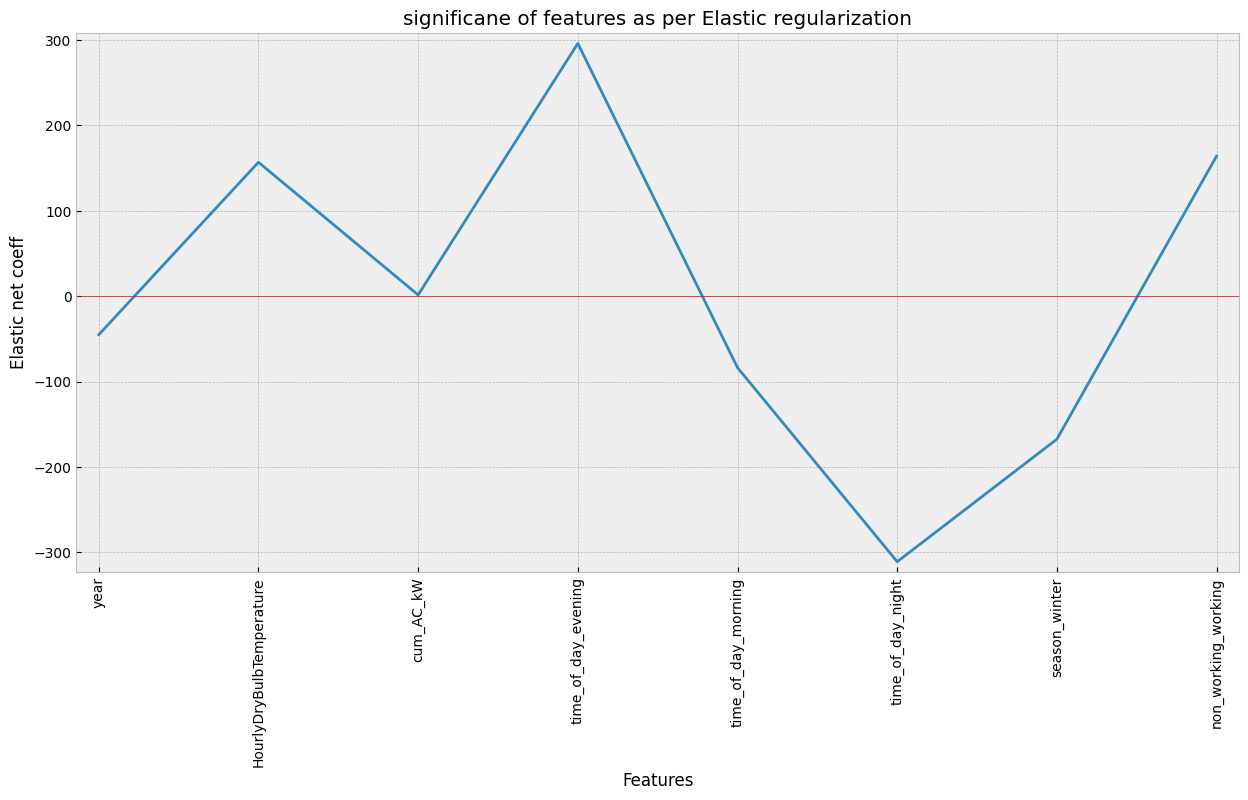

<Figure size 500x500 with 0 Axes>

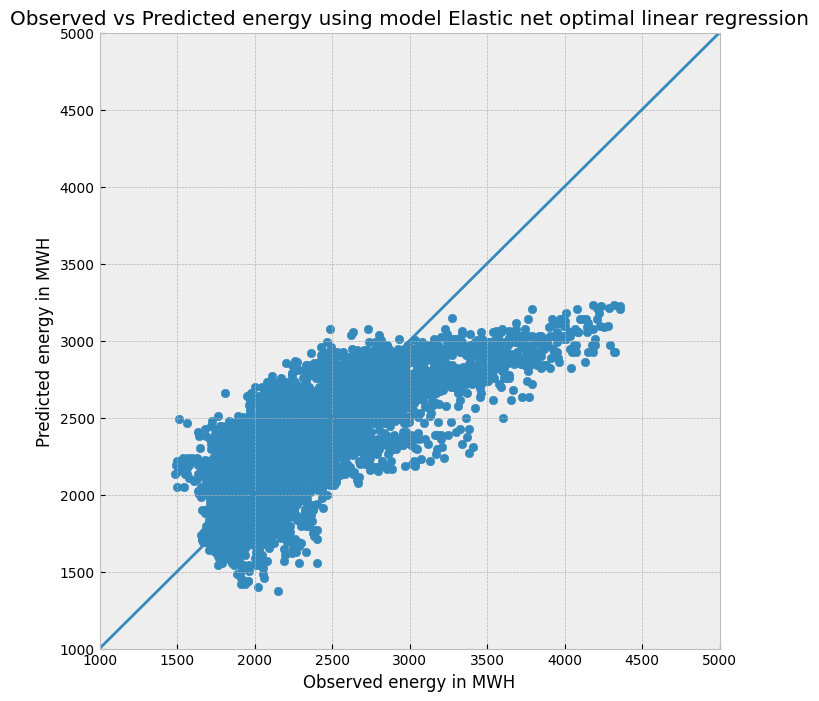

In [51]:
# Fitting, tuning and predicting using the best elastic net regression model
import warnings  
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test, elastic_net_opt = trend_model(data=data, cols_to_transform=cols_to_transform, 
                                                                l1_space=l1_space, alpha_space=alpha_space,
                                                                scale = True, test_size = 0.15, include_test_scale=False)

In [52]:
# Plotting the observed test energy and predicted energy data on the same graph as line plots

plot_ts_pred(y_test, elastic_net_opt.predict(X_test), model_name='Optimal Elastic net regression', \
             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

In [53]:
# printing the error metrics
print('Elastic net regression on training set')
error_metrics(elastic_net_opt.predict(X_train), y_train, model_name = 'Tuned elastic net regression with reduced hour space', 
              test = False)

print('\nElastic net regression on test set')
error_metrics(elastic_net_opt.predict(X_test), y_test, model_name = 'Tuned elastic net regression with reduced hour space', 
              test = True)

Elastic net regression on training set

Error metrics for model Tuned elastic net regression with reduced hour space
RMSE or Root mean squared error: 277.96
Variance score: 0.66
Mean Absolute Error: 212.49
Mean Absolute Percentage Error: 9.00 %

Elastic net regression on test set

Error metrics for model Tuned elastic net regression with reduced hour space
RMSE or Root mean squared error: 311.88
Variance score: 0.60
Mean Absolute Error: 236.89
Mean Absolute Percentage Error: 9.98 %


* The optimized model here has a l1_ratio which is close to 1 which means it is almost like a Lasso regression model ($L1$ regularization).
* We see that the regression model's performance decreases by clubbing the hours into larger bins. In fact in terms of MAPE, it performs poorer than the baseline model on the test set.


***
# 4. Random Forest Regression <a name="4"></a>
***

### Trying Random Forest regression on the above reduced X space (clubbing hours into larger bins)

* Usually the Random forest doesn't perform very well on a time series problem and most often than not it will overfit the data and predict poorly on the test set. But the performane of random forest on a time series problem can be improved by some feature engineering.
* Let's try to fit random forest on the basic reduced space dataset that we fitted our tuned elastic model on.

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
# Tuning Random forest
# n_estimators = number of trees in the forest
# max_features = max number of features considered for splitting a node

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
max_features = ['auto', 'sqrt']
max_depth = list(range(1,6))
# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5]}


In [56]:
#import randomsearchcv
from sklearn.model_selection import RandomizedSearchCV

# First create the base model to tune
rf = RandomForestRegressor()

# Creating a time series split as discussed in the Introduction
tscv = TimeSeriesSplit(n_splits=5)
# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_
#rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

{'n_estimators': 73, 'max_features': 'sqrt', 'max_depth': 3}

In [57]:
rf_random.score(X_train, y_train)

0.6583732479418669

In [58]:
rf_random.score(X_test, y_test) # expect to see overfitting here

0.5950219602783966

In [59]:
# Plotting the observed test energy and predicted energy data on the same graph as line plots

plot_ts_pred(y_test, rf_random.predict(X_test), model_name='Tuned Random forest with reduced hour space', \
             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

In [60]:
# Random forest error metrics

print('Tuned Random forest errors on training set')
error_metrics(rf_random.predict(X_train), y_train, model_name = 'Tuned Random forest with reduced hour space', test = False)
print('\nTuned Random forest errors on test set')
error_metrics(rf_random.predict(X_test), y_test, model_name = 'Tuned Random forest with reduced hour space', test = True)


Tuned Random forest errors on training set

Error metrics for model Tuned Random forest with reduced hour space
RMSE or Root mean squared error: 279.93
Variance score: 0.66
Mean Absolute Error: 210.30
Mean Absolute Percentage Error: 8.89 %

Tuned Random forest errors on test set

Error metrics for model Tuned Random forest with reduced hour space
RMSE or Root mean squared error: 313.58
Variance score: 0.60
Mean Absolute Error: 237.99
Mean Absolute Percentage Error: 10.12 %


* The above RF model performs similar to the elastic net regression.

***
# 5. Adding lags as X variables (Elastic Net & RF) <a name="5"></a>
***

### Adding lags to our data

What makes the time series different from other datasets is that the current y value depends on the previous N values in time depending on the correlation of the data with its lagged version. For example, today's outside temperature can depend on yesterday's outside temperature or maybe depend on the last 5 days of temperature values. The energy consumption values can also be expected to depend on it's previous lagged values because energy consumption of a region shouldn't be expected to change much except for any unexpected or unfortunate events. So we will add the lagged values of energy consumtpion as the X parameters and check if we can predict better using the past values.


In [61]:
sdge1_lin.head(2)

,SDGE,year,HourlyDryBulbTemperature,cum_AC_kW,time_of_day_evening,time_of_day_morning,time_of_day_night,season_winter,non_working_working
Dates,,,,,,,,,
2014-01-01 00:00:00,2096.0,2014,51.0,220992.227,False,False,True,True,False
2014-01-01 01:00:00,1986.0,2014,51.5,220992.227,False,False,True,True,False


In [62]:
# Adding max 24 lags; lag1 is the value of the energy consumption in the previous hour, lag2 is the value of energy consumption..
#..2 hours before the current value and so on.

# Creating the lag variables
for i in range(24):
    sdge1_lin['lag'+str(i+1)] = sdge1_lin['SDGE'].shift(i+1)

In [63]:
# Since the first 24 values won't have any 24th lag, they will be NaN. So dropping the NaNs
lag_sdge = sdge1_lin.dropna()

In [64]:
lag_sdge.head(2)

,SDGE,year,HourlyDryBulbTemperature,cum_AC_kW,time_of_day_evening,time_of_day_morning,time_of_day_night,season_winter,non_working_working,lag1,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
Dates,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00,1904.0,2014,53.0,221141.892,False,False,True,True,True,2041.0,...,2250.0,2141.0,2055.0,2011.0,1922.0,1899.0,1896.0,1936.0,1986.0,2096.0
2014-01-02 01:00:00,1855.0,2014,52.0,221141.892,False,False,True,True,True,1904.0,...,2304.0,2250.0,2141.0,2055.0,2011.0,1922.0,1899.0,1896.0,1936.0,1986.0


### Fitting Elastic Net Regression on the Lag data

In [65]:
# Fitting Elastic Net Regression model using the lag variables as the additional inputs ...
#...(extending the reduced space model)

# Not tuning the elastic net this time because we will see that there hardly any scope for improvement in the excellent results
#..we get

cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW', 'year']
# Adding the energy consumption lags to the columns to transform 
list_lags = ['lag'+str(i+1) for i in range(24)]
cols_to_transform.extend(list_lags)

X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test(lag_sdge, \
                                                              test_size = 0.15, scale = True, \
                                                              cols_to_transform=cols_to_transform)

In [66]:
elastic_net_lag = ElasticNet(l1_ratio = 1, alpha=0.2)
elastic_net_lag.fit(X_train_lag, y_train_lag)

ElasticNet(alpha=0.2, l1_ratio=1)

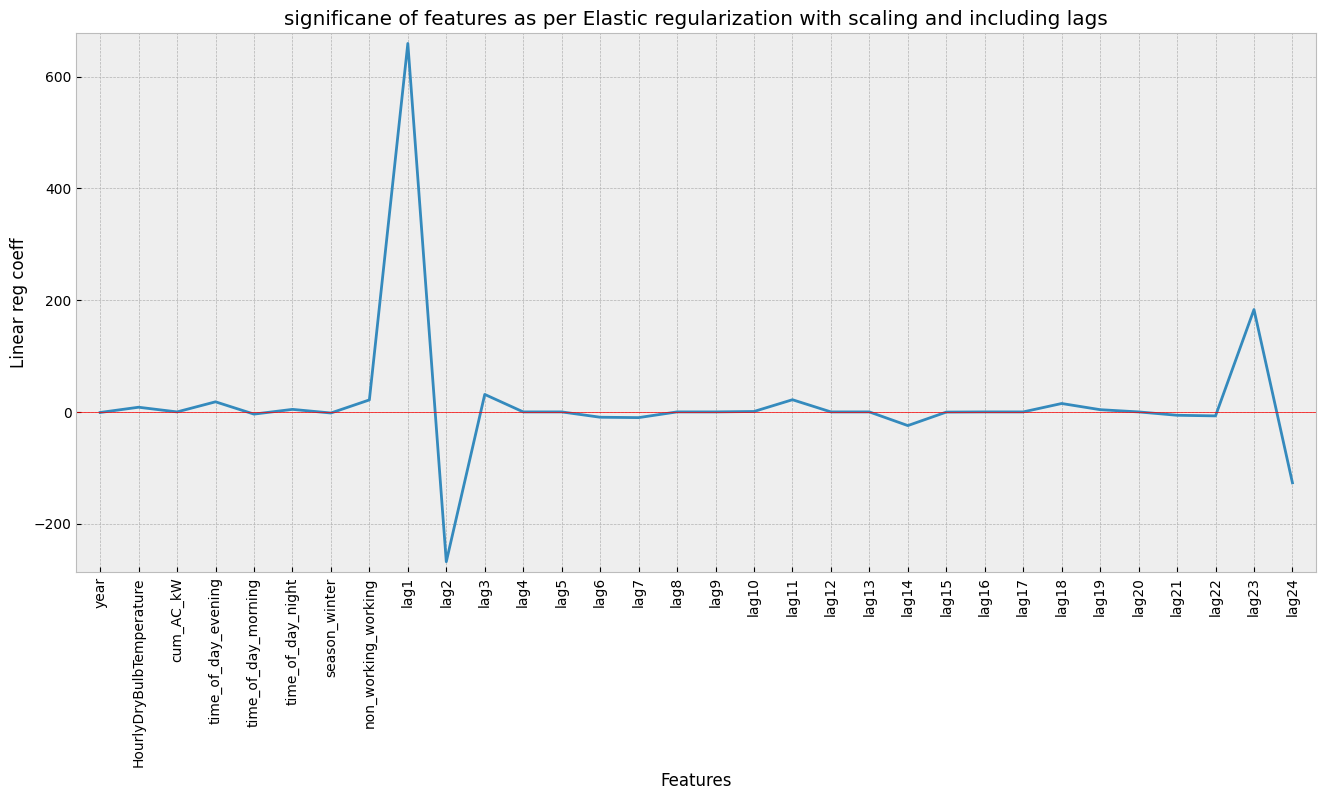

In [67]:
# Plot the coefficients
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train_lag.columns)), elastic_net_lag.coef_)
_ = plt.xticks(range(len(X_train_lag.columns)), X_train_lag.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('significane of features as per Elastic regularization with scaling and including lags')
_ = plt.ylabel('Linear reg coeff')
_ = plt.xlabel('Features')

In [68]:
X_train_lag.columns.values

array(['year', 'HourlyDryBulbTemperature', 'cum_AC_kW',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'season_winter', 'non_working_working', 'lag1', 'lag2', 'lag3',
       'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11',
       'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17', 'lag18',
       'lag19', 'lag20', 'lag21', 'lag22', 'lag23', 'lag24'], dtype=object)

### Fitting Random Forest on the lag data

In [69]:
#rflag = RandomForestRegressor()
#rflag.fit()

# First create the base model to tune
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
# Random search of parameters
rflag = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)

# Fit the random search model
rflag.fit(X_train_lag, y_train_lag)

rflag.best_params_
#rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

{'n_estimators': 73, 'max_features': 'auto', 'max_depth': 5}

In [70]:
# comparison of scores using elastic net and RF on the lag dataset

print('Random forest errors with lags on training')
error_metrics(rflag.predict(X_train_lag), y_train_lag, model_name = 'Random forest with all lags', test=False)
print('\nRandom forest errors with lags on test')
error_metrics(rflag.predict(X_test_lag), y_test_lag, model_name = 'Random forest with all lags', test=True)
print('\nElastic net errors with lags on train')
error_metrics(elastic_net_lag.predict(X_train_lag), y_train_lag, model_name = 'Elastic net with all lags', test=False)
print('\nElastic net errors with lags on test')
error_metrics(elastic_net_lag.predict(X_test_lag), y_test_lag, model_name = 'Elastic net with all lags', test=True)

Random forest errors with lags on training

Error metrics for model Random forest with all lags
RMSE or Root mean squared error: 79.81
Variance score: 0.97
Mean Absolute Error: 60.77
Mean Absolute Percentage Error: 2.58 %

Random forest errors with lags on test

Error metrics for model Random forest with all lags
RMSE or Root mean squared error: 84.14
Variance score: 0.97
Mean Absolute Error: 64.00
Mean Absolute Percentage Error: 2.75 %

Elastic net errors with lags on train

Error metrics for model Elastic net with all lags
RMSE or Root mean squared error: 51.59
Variance score: 0.99
Mean Absolute Error: 36.36
Mean Absolute Percentage Error: 1.51 %

Elastic net errors with lags on test

Error metrics for model Elastic net with all lags
RMSE or Root mean squared error: 50.75
Variance score: 0.99
Mean Absolute Error: 37.36
Mean Absolute Percentage Error: 1.58 %


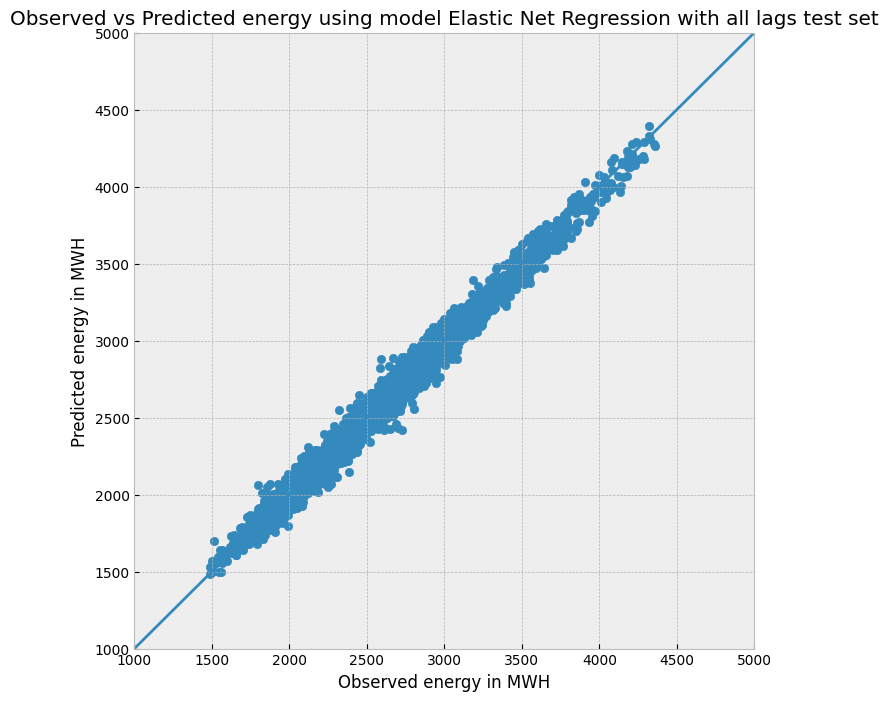

In [71]:
plot_predvstrue_reg(elastic_net_lag.predict(X_test_lag), y_test_lag, 
                    model_name = 'Elastic Net Regression with all lags test set')

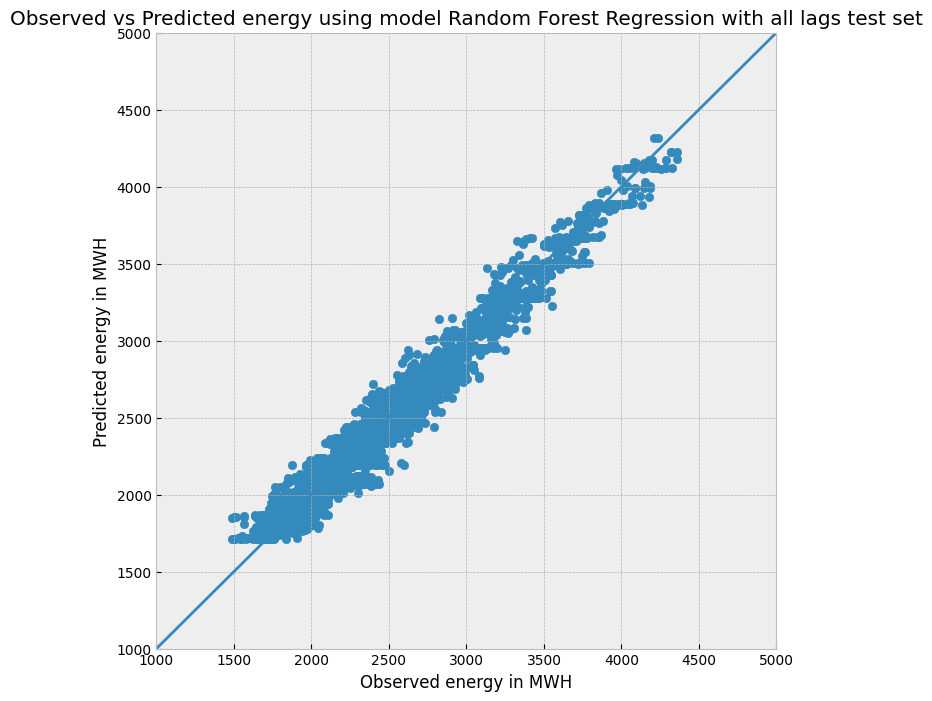

In [72]:
plot_predvstrue_reg(rflag.predict(X_test_lag), y_test_lag, 
                    model_name = 'Random Forest Regression with all lags test set')

In [73]:
# Plotting the observed test values, and predicted test values using the above Elastic net and Random forest models using lags
#..up to last 24 hour values

fig = go.Figure()

fig.add_trace(go.Scatter(x = X_test_lag.index, y = np.array(y_test_lag), name = "observed",
                         line_color = 'deepskyblue', opacity = 0.5))

fig.add_trace(go.Scatter(x = X_test_lag.index, y = rflag.predict(X_test_lag), name = "Random forest predictions",
                         line_color = 'lightslategrey', opacity = 0.5))

fig.add_trace(go.Scatter(x = X_test_lag.index, y = elastic_net_lag.predict(X_test_lag), name = "Elastic net predictions",
                         line_color = 'lightcoral', opacity = 0.5))

fig.update_layout(title_text = 'Observed test set vs Predicted energy using Random forest & elastic net \
reg using lags upto 24h on test set',
                  xaxis_rangeslider_visible = True)
fig.show()

* Both Elastic net and Random Forest models give excellent performance by using all lags up to past 24 hours. Elastic net seems to perform better than Random Forest here and since the independent variables like cum_AC_kW which is the cumulative solar panel installations in kW till current date and also the Hourly Bulb temperature are linearly correlated with the energy consumption the first preference should be a linear model like the elastic net regression. 
* From the coefficient plot it can be seen how the first and the 23rd lags are the most important predictors. 
* This model performs very well but it comes with a limitation- we can use it to predict only the next hour value. That is, the maximum time window it can predict accurately is 1 hour. So, if that is the application case then the elastic net model with previous lag values should be used.
***

***
# 6. Time Series Features and Models <a name="6"></a>
***

## 6.1. Basic Time series structure, Stationarity, Auto Correlation <a name="6.1"></a>
***

Here is a good article explaining the nitty gritties of a time series data in detail : [link](https://medium.com/greyatom/time-series-b6ef79c27d31)

In [74]:
# Creating a simple time series dataframe
ts_sdge = pd.DataFrame(sdge1_lin["SDGE"], columns=['SDGE'])

In [75]:
ts_sdge.tail()

,SDGE
Dates,
2018-12-31 19:00:00,2609.685890
2018-12-31 20:00:00,2504.283858
2018-12-31 21:00:00,2389.460971
2018-12-31 22:00:00,2259.741640
2018-12-31 23:00:00,2123.183153


In [76]:
# Plotting our original time series
plot_timeseries(ts_sdge['SDGE'], title = 'Original data set')

#### Let's decompose the time series to identify its multiple components 

In [77]:
from statsmodels.graphics import tsaplots

In [78]:
import statsmodels.api as sm

# Run seasonal decompose
decomp = sm.tsa.seasonal_decompose(ts_sdge['SDGE'], freq=24*365) # capturing the yearly seasonal component; i.e. for example 
#... every July the energy consumption is high and then it gets lower during the winter months. 
#...So, a periodicity of 24hours*365 was used here.

print(decomp.seasonal.head()) # checking the seasonal component
_ = decomp.plot()

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

* The sm.tsa.seasonal_decompose does a pretty good job of decomposing our energy consumption dataset, especially when we tell it that our data has a periodicity of 24*365 hours. 
* The trend shows how the energy consumption decreases over the years from 2014-18 which we had already inferred from the linear regression coefficient values for the year variable from the linear regression models. But, another important thing to keep in mind here is that the trend, though observably clear, is very small.
* The seasonal component captures the summer and winter trends very well too. 

In [ ]:
ts_sdge['seasonal'] = decomp.seasonal

In [ ]:
# Plotting the seasonal coponent only
plot_timeseries(ts_sdge['seasonal'], title = 'Seasonal component')

In [ ]:
ts_sdge['trend'] = decomp.trend

In [ ]:
# Plotting the trend (the starting 6 months and the end 6 months of data is NaN because we had set the periodicity as 24*365,
#... so the trend data will have 8760 less values)
ts_sdge['trend'].dropna().plot()

#### We can also check the trend using the pandas rolling method

In [ ]:
# Plotting the half yearly rolling average of the time series to check trend (mean consumption)

_ = sdge['SDGE'].rolling(window = 24*30*12).mean().plot(figsize=(12,5))
_ = plt.title('Checking trend in the data by averaging yearly values')


In [ ]:
# Plotting the quartely rolling MAX of the time series to check trend
_ = sdge['SDGE'].rolling(window = 24*30*12).max().plot(figsize=(12,5))
_ = plt.title('Checking trend in the data by taking the MAX of yearly values')

* We can observe a downward trend in the data as observed using the decompose method above

### Stationarity 

Before we move forward we need to discuss an important property of the time series data which is Stationarity.

* If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The latter is called homoscedasticity). The covariance function does not depend on time; it should only depend on the distance between observations. 
* __Why is stationarity so important?__ Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Future predictions would be wrong if the original series were not stationary.

From the above definition of stationarity it is clear that our energy consumption dataset is not stationary because it has a trend (changing mean) and also seasonality which means that the covariance function does depend on time. The simplest way to identify stationarity (or its absence) is viewing the data as we did above by decomposing it but the most common way of testing a dataset for stationarity is the __Dicky Fuller test__ which tests for a unit root. Basically, if the p-value of the test is too small (say less than 0.05, giving us 95% confidence) then we reject the hypothesis that our data is non-stationary and assume that it is stationary indeed.

***
And the most common way of dealing with stationarity is differencing our dataset. Let's see some examples below.

In [ ]:
# Differencing the data once

decomp_diff1 = sm.tsa.seasonal_decompose(ts_sdge['SDGE'].diff().dropna(), freq=24*365) 
_ = decomp_diff1.plot()

* Comparing the above differenced plot with the previous original data plot we can see how the trend was removed by differencing just once and also the effect of seasonality was also reduced.

***
* To deal with seasonality we can difference the dataset with the periodicity of the seasons. Let's difference the dataset by its smallest period which is 24 hours here. 

In [ ]:
# Differencing the data with periodicity of 24 hours in addition to the original single differencing

decomp_diff24 = sm.tsa.seasonal_decompose(ts_sdge['SDGE'].diff().dropna().diff(24).dropna(), freq=24*365) 
_ = decomp_diff24.plot()


* Differencing the dataset once and then with the period of 24 hours further diminishes any trend and seasonality effects and seems to render the dataset stationary.

#### Conducting the Dicky Fuller test of Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

#### Testing for stationarity

In [ ]:
def run_adfuller(ts):
    result = adfuller(ts)
    # Print test statistic
    print("t-stat", result[0])
    # Print p-value
    print("p-value", result[1])
    # Print #lags used
    print("#lags used", result[2])
    # Print critical values
    print("critical values", result[4]) 

In [ ]:
print("for no differencing\n")
run_adfuller(ts_sdge['SDGE'])
print("\nfor single differencing\n")
run_adfuller(ts_sdge['SDGE'].diff().dropna())
print("\nfor differenced data set over lags 24 after single differencing\n")
run_adfuller(ts_sdge['SDGE'].diff().dropna().diff(24).dropna())

* Based on the p-values of the above tests it seems that even our original dataset is stationary but if we check the t-stat values it is obvious that the stationarity gets more significant with differencing. The original dataset was declared stationary by the test maybe because the trend in our data is very weak (as evident from the decomposed plot). So, we can either use the original dataset as it is with the time series models (as we have done for the linear regression models before), or to be more robust we can use the single differencing to remove the trend and fit our models on the detrended data. 

### Exponential smoothing

Simple techniques like rolling average of the past values is often useful to visualize the trend in a dataset. The simplest model for a time series will be a persistent model where simply $y_t = y_{t-1}$. Most of the times the time series models are compared to this naive model to test their performance. A more advance smoothing technique is called exponential smoothing and it is given as:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

In [ ]:
# Defining a function to plot exponentially smoothed data
def plot_ewma(ts, alpha):
    expw_ma = ts.ewm(alpha=alpha).mean()
    
    plot_ts_pred(ts, expw_ma, model_name='Exponentially smoothed data with alpha = {}'.format(alpha), \
                 og_ts_opacity = 0.5, pred_ts_opacity = 0.5)


In [ ]:
# Plotting the exponentially smoothed energy consumption data with alpha=0.3
plot_ewma(ts_sdge['SDGE'], 0.3)

The EWMA does a good job of modeling the future values but it requires N number of lag variables depending on the value of alpha and also it's a very simplistic model for our energy consumption data.

There are other advanced models like the Triple exponential smoothing a.k.a Holt Winters model but I am skipping that model here because we can try better models like FB Prophet and ARIMA on our data (which seems to have a trend and multiple seasonality).

### Correlation with the past values


The correlation of the time series observations calculated with values of the same series at previous times, is called a serial correlation, or an autocorrelation (ACF). It is used to determine the moving average (MA or q) term of the ARIMA(p,d,q) models.

A partial autocorrelation (PACF) is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. It is used to determine the auto regression (AR or p) term of the ARIMA(p,d,q) models.

And we have observed till now that our energy consumption time series has a strong correlation with its past day value (lag of 24 hours) and also its past value 365*24 hours ago. In addition a weekly seasonality is also observed in the energy consumption. Let's plot the ACF and PACF plots for our energy time series data.

#### Plotting the ACF and PACF plots


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def acf_pacf_plots(ts, lags, figsize = (12,8)):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)
    
    # Plot the ACF of ts
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)

    # Plot the PACF of ts
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)

In [ ]:
# Create the acf and pacf plots

dfacf = []
dfacf = ts_sdge['SDGE']
lags = 50

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

The seasonal period of 24 hours can be easily observed from the plots above.

In [ ]:
# Differencing the data this time to remove the trend and seasonality
dfacf = []
dfacf = ts_sdge['SDGE']
dfacf = dfacf.diff().dropna() 
dfacf = dfacf.diff(24).dropna()
dfacf = dfacf.diff(24*365).dropna()
lags = 100

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

Even after differencing and seasonal differencing the data, the ACF and PACF plots are not very informative, they do not tell us which AR and MA terms will be good for the SARIMAX model (S stands for seasonality and X for exogenous variables).

This is a common pitfall of the ACF, PACF plots and SARIMAX models. They cannot handle multiple seasonality. And our energy consumption dataset has multiple seasonalities - daily (24 hours), weekly (168hours), yearly (24*365.25). We'll have to deal with the multiple seasonality separately to be able to use SARIMAX model on our energy consumption time series

***
## 6.2. Handling Multiple seasonality <a name="6.2"></a>
***

There are two interesting time series forecasting methods called BATS and TBATS that are capable of modeling time series with multiple seasonalities [link](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a). Unfortunately BATS and TBATS capabilities do not come for free. The method is very generic. Under the hood it builds and evaluates many model candidates. This results in slowness of the computation. And SARIMAX models with Fourier series handling the multiple seasonalities can perform as good as the TBATS model, so we will opt for the simpler model here i.e. SARIMAX. We will need to create some extra features here to model the multiple seasonalities.


### Adding fourier cyclical series for hour, year and week periods

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# We can add multiple fourer series with different k terms in the (2*k*pi) such as k=1,2,3...etc. To generalize the problem, 
# we could have chosen an optimal k value for each season by trying out some k values and choosing the values giving 
#the lowest AIC.

def add_fourier_terms(df, year_k, week_k, day_k):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
    sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:same as year_k but for daily periods
    """
    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, week_k+1):
        
        # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)


    for k in range(1, day_k+1):
        
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24) 

In [ ]:
warnings.filterwarnings('ignore')

# as said above the k terms for each yearly, weekly and daily seasonalities could be chosen by optimizing on the AIC values..
# but after some research on energy consumption time series k= 5 was chosen for each seasonality
add_fourier_terms(lag_sdge, year_k= 5, week_k=5 , day_k=5)

In [ ]:
#ph = -0.7
#y1 = np.sin(2 * np.pi * lag_sdge.index.hour/24+ph) + np.cos(2 * np.pi * lag_sdge.index.hour/24+ph)
#y2 = np.sin(2 * 2* np.pi * lag_sdge.index.hour/24) + 0.7*np.cos(2 *2* np.pi * lag_sdge.index.hour/24)
#y3 = np.sin(2 * 2* np.pi * lag_sdge.index.hour/24) + np.cos(2 *2* np.pi * lag_sdge.index.hour/24)

#plt.plot(lag_sdge.index, 1-(y1+y2))
#plt.xlim(['2014-01-02', '2014-01-03'])
#plt.xticks(rotation=90)

In [ ]:
# Visualizing the new variables on hour seasonality
pd.plotting.register_matplotlib_converters()
_ = (1-lag_sdge.loc['01-02-2014':'01-02-2014', [col for col in lag_sdge if col.startswith('hour')]]).sum(axis = 1).plot()

In [ ]:
# Visualizing the new variables on year seasonality
_ = (1-lag_sdge.loc['01-01-2014':'01-01-2015', [col for col in lag_sdge if col.startswith('year')]]).sum(axis = 1).plot()

In [ ]:
# Visualizing the new variables on week seasonality
_ = (1-lag_sdge.loc['01-01-2014':'01-09-2014', [col for col in lag_sdge if col.startswith('week')]]).sum(axis = 1).plot()

In [ ]:
lag_sdge.columns

In [ ]:
# Choosing a subset of the above dataframe; removing the lags and the hour bins
sdgecyc = lag_sdge.drop([col for col in lag_sdge if 
                         col.startswith('time') or col.startswith('season') or col.startswith('lag')], axis=1)

***
## 6.3. SARIMAX <a name="6.3"></a>
***

__Trying the SARIMAX model on the above fourier series added dataset__

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
import pmdarima as pm

In [ ]:
# defining the exogenous variables for the SARIMAX model
#sdgecyc.drop('SDGE', axis=1)

* The SARIMAX model takes many inputs which require some tuning to be able to pick the best model parameters. $pmdarima$ package's auto_arima module automates this task and gives us the best model by taking in some input ranges, similar to gridsearchcv. 

In [ ]:
sdgecyc.columns

In [ ]:
# Creating the training and test datasets
# check https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

# not adding year variable here because the model will use the most recent lag energy consumption values
cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW']  
X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test(sdgecyc, 
                                                              test_size = 0.15, scale = True, 
                                                              cols_to_transform=cols_to_transform)

# Since ARIMA model uses the past lag y values, scaling the energy values as well. 
#i.e. fit the scaler on y_train and transform it and also transform y_test using the same scaler if required later

scaler1 = StandardScaler()
y_train_lag = pd.DataFrame(scaler1.fit_transform(y_train_lag.values.reshape(-1,1)), index = y_train_lag.index, 
                           columns = ['SDGE'])
# y_test_lag = scaler1.transform(y_test_lag)

In [ ]:
# Got the optimal SARIMAX order from running the above auto_arima function. It took more than 2 hours to get the optimal...
#...solution. So, just using the final values here
model_opt = SARIMAX(y_train_lag, order=(2,1,1), seasonal_order=(1, 0, 1, 24), exog = X_train_lag, trend='c')

In [ ]:
results = model_opt.fit()

In [ ]:
results.summary()

In [ ]:
#X_train_lag.columns

In [ ]:
# plotting the residuals and checking if they meet the i.i.d requirements
_ = results.plot_diagnostics(figsize=(12, 7))

In [ ]:
# Predictions on train set. Predicting only the last week of the training set

# Setting dynamic = True so that the model won't use actual enegy values for prediction. Basically the model will use
# the lag terms and moving average terms of the already forecasted energy values. So, we will see the errors 
#(confidence interval) increasing with each forecast.
pred = results.get_prediction(start=X_train_lag.index[-24*7], end=X_train_lag.index[-1], 
                              dynamic=True, exog=X_train_lag.iloc[-24*7:, :])
pred_ci = pred.conf_int()

pred1 = scaler1.inverse_transform(pred.predicted_mean)
pred_ci1 = scaler1.inverse_transform(pred.conf_int())

y_actual_train = np.squeeze(scaler1.inverse_transform(y_train_lag))
y_actual_train = pd.Series(y_actual_train, index = X_train_lag.index )

pred1 = pd.Series(pred1, index = X_train_lag.iloc[-24*7:, :].index )
pred_ci1 = pd.DataFrame(pred_ci1, index = pred1.index, columns = ['lower SDGE', 'upper SDGE'])

lower_limits = pred_ci1.loc[:,'lower SDGE']
upper_limits = pred_ci1.loc[:,'upper SDGE']

In [ ]:
# Error on training set for 1 week ahead forecast
error_metrics(pred1, y_actual_train.iloc[-24*7:], 'SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week', 
              test=False) 

In [ ]:
#plot_ts_pred(y_actual_train.iloc[-24*7:], pred1 , model_name='SARIMA (0,1,2)x(1,0,1,24)', 
#             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)
# plot the predictions
plt.figure(figsize = (15,7))
_ = plt.plot(y_actual_train.iloc[-24*7:].index, y_actual_train.iloc[-24*7:], label='observed')

# plot your mean predictions
_ = plt.plot(pred1.index, pred1.values, color='r', label='forecast')

# shade the area between your confidence limits
_ = plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy consumption MWH')
_ = plt.legend()
_ = plt.title('Testing the SARIMAX (2,1,1)x(1,0,1,24) model on the training set: predicting the last week')

In [ ]:
# Predictions on test set. Predicting only the 1st week of the test set
pred = results.get_forecast(steps = 24*7, exog = X_test_lag.iloc[:24*7, :])
pred_ci = pred.conf_int()

pred2 = scaler1.inverse_transform(pred.predicted_mean)
pred_ci2 = scaler1.inverse_transform(pred.conf_int())

y_actual = y_test_lag.iloc[:24*7]

pred2 = pd.Series(pred2, index = X_test_lag.iloc[:24*7, :].index )
pred_ci2 = pd.DataFrame(pred_ci2, index = pred2.index, columns = ['lower SDGE', 'upper SDGE'])

lower_limits = pred_ci2.loc[:,'lower SDGE']
upper_limits = pred_ci2.loc[:,'upper SDGE']

# plot the predictions
plt.figure(figsize = (15,7))
_ = plt.plot(y_actual.index, y_actual, label='observed')

# plot your mean predictions
_ = plt.plot(pred2.index, pred2.values, color='r', label='forecast')

# shade the area between your confidence limits
_ = plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy consumption MWH')
_ = plt.legend()
_ = plt.title('Testing the SARIMAX (2,1,1)x(1,0,1,24) model on the testing set: predicting the 1st week')

In [ ]:
# Checking if the SARIMA model captures the long term seasonality 
#plot_ts_pred(y_actual, pred1 , model_name='SARIMA (0,1,2)x(1,0,1,24)', 
#             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

# It fails terribly to capture the long term seasonality

In [ ]:
error_metrics(pred2, y_actual, 'SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week', test=True) 

***
* We see that the first week forecast is pretty well but even at the end of first week the forecasting performance decreases and the confidence interval values grow larger beyond the scale of the range of the energy consumption values. Thus, SARIMAX model was not able to capture long term trends but it did well on 1 week ahead forecast.
* SARIMA models don't capture multiple seasonalities well and are also very time consuming. So, it won't be the first choice if we need both a quick and accurate forecast.
* Errors for 1 hour ahead forecasts weren't calculated above for SARIMAX model (by usign dynamic=True) because we get excellent results using elastic net regression for 1 hour ahead forecasts using the lag variables and it is much faster to fit than SARIMAX. So, if 1 hour ahead forecasting is the goal then elastic net regression should be used.

In [ ]:
sdgecyc.head(2)

***
## 6.4. FB Prophet <a name="6.4"></a>
***

Traditional approaches like SARIMA models often require manual data pre-processing steps (e.g. differencing to make the data stationary) and it’s also hard to explain why these models produce the prediction results to people without forecasting expertise. In addition, these models are not allowed to add additional domain knowledge to improve precision. For solving these problems, Facebook researchers recently released FBProphet, a time series forecasting tool supporting both Python and R.  
  
FBProphet provides a decomposition regression model that is extendable and configurable with interpretable parameters. Prophet frames the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series. Similar to SARIMAX, we can add extra regressor terms like temperature data to the model as well.

At it’s core, Prophet is an additive model with the following components:
$$y(t) = g(t) + s(t) + h(t) + ϵₜ$$  

$g(t)$ models trend, which describes long-term increase or decrease in the data. Prophet incorporates two trend models, a saturating growth model and a piecewise linear model, depending on the type of forecasting problem.  
$s(t)$ models seasonality with Fourier series, which describes how data is affected by seasonal factors such as the time of the year    
$h(t)$ models the effects of holidays or large events that impact business time series (e.g. new product launch, Black Friday, Superbowl, etc.)  
$ϵₜ$ represents an irreducible error term  

[Ref1](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3)  
[Ref2](https://dius.com.au/2018/09/04/time-series-forecasting-with-fbprophet/)  
[Ref3](https://towardsdatascience.com/forecasting-with-prophet-d50bbfe95f91)

***
* Using only the 'SDGE', 'HourlyDryBulbTemperature','cum_AC_kW', 'non_working_working' columns while using Prophet because Prophet, unlike SARIMAX, handles multiple seasonalities well. So, we don't need to pass in the Fourier terms separately.
* FB Prophet can be passed with a holiday feature, but since we have already captured the holidays and weekends in the 'non_working_working' column we won't pass a separate holiday list to Prophet.

In [ ]:
# cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW']
X_trainP, X_testP, y_trainP, y_testP = train_test\
                           (lag_sdge[['SDGE', 'HourlyDryBulbTemperature','cum_AC_kW', 'non_working_working']], 
                           test_size=0.15, 
                           scale=False, #True
                           #cols_to_transform=cols_to_transform,
                           include_test_scale=False)

Prophet requires the input data in a particular format, so preparing the data for Prophet.

In [ ]:
# preparing data for Prophet
def data_prophet(X_train, X_test, y_train, y_test):
    data_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
    data_train = data_train.reset_index().rename(columns = {'SDGE':'y', 'Dates':'ds'})
    data_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
    data_test  = data_test.reset_index().rename(columns = {'SDGE':'y', 'Dates':'ds'})
    return data_train, data_test

In [ ]:
data_train, data_test = data_prophet(X_trainP, X_testP, y_trainP, y_testP)

In [ ]:
data_train.tail(3)

In [ ]:
# Importing Prophet
from fbprophet import Prophet

In [ ]:
# Initiating fbprophet model; set the uncertainty interval to 95% (the Prophet default is 80%)
prop = Prophet(growth='linear', interval_width = 0.95, 
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                seasonality_mode='additive',
                #seasonality_prior_scale = 15
              )

* We can add the seasonalities separately in the Prophet model by replacing the 'auto' mode of the seasonalities above with 'FALSE'. Then we can add the yearly, weekly, daily, monthly, quarterly, etc. seasonalities using the .add_seasoanlity feature of the Prophet specifying the period in days for a seasonality along with the fourier terms to be used and the prior_scale to set. 
* After some trial and error it was concluded that for this problem adding seasonalities manually doesn't give better results than the 'auto' mode, so keeping the seasonality as 'auto'.
* There are two mode options for any seasonality - 'additive' or 'multiplicaitve'. Multiplicaitve should be used if the seasonality affects the trend exponentially. 
* External regressor like the temperature column are added to the model by using the 'add_regressor' function of the Prophet. There is an option for Standardization while passing the regressors, so Scaler wasn't used abobe while creating the train and test splits.

In [ ]:
# Adding seasonality
#prop.add_seasonality(name='daily', period = 1, fourier_order = 15, prior_scale=20)
#prop.add_seasonality(name='weekly', period = 7, fourier_order = 10, prior_scale=20)
#prop.add_seasonality(name='yearly', period = 365.25, fourier_order = 20, prior_scale=20)

# Adding regressors
prop.add_regressor('HourlyDryBulbTemperature', prior_scale=20, mode='additive', standardize=True)
prop.add_regressor('cum_AC_kW', prior_scale = 1, mode='additive', standardize=True)
prop.add_regressor('non_working_working', prior_scale=10, mode='additive', standardize='auto') #'auto'=> standardize if not
#.binary


In [ ]:
# Fitting the model to training data
prop.fit(data_train)

In [ ]:
# Creating the dataframe with datetime values to predict on (making predictions on train as well as the test set)
future_dates = prop.make_future_dataframe(periods=len(data_test), freq='H', include_history=True)
# Aadding regressors 
future_dates = pd.merge(future_dates, (data_train.append(data_test)).drop('y', axis=1), on = 'ds')

In [ ]:
future_dates.tail(3)

In [ ]:
# Predicting the future
forecast = prop.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
#pd.plotting.register_matplotlib_converters()
_ = prop.plot(forecast, uncertainty = True, xlabel = 'Dates', ylabel = 'Energy consumption MWH')

In [ ]:
# Plotting the components of the results
_ = prop.plot_components(forecast)

* We can see that the multiple seasonalities were captured very well by the Prophet model. 
* In the bottom most plot, the extra regressor additve terms include the temperature, non_working_working and cum_AC_kW variables. We see the impact of temperature and working days in the form of wiggles whereas the overall impact of the cum_AC_kW is a downward trend in the energy (as was expected since more PV gets installed at customer sites, the lower the demand on the grid).

In [ ]:
#pd.plotting.register_matplotlib_converters()

plot_ts_pred(data_train.append(data_test).set_index('ds')['y'], forecast.set_index('ds')['yhat'], \
             model_name='FB Prophet with auto seasonality', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

***
FB Prophet also provides an option for performing cross validation on the training set. It needs an inital, period and horizon as inputs. $Initial$ is the training sub set to be used for training the model on, $period$ is the number of time frames the data should be shifted forward by for extending the training subset and $horizon$ is the window of forecast. This is similar to the time series split described in the Introduction.

In [ ]:
from fbprophet.diagnostics import cross_validation

In [ ]:
len(y_trainP)*2//3

Randomly checking the performance of FB Prophet on 1 week ahead forecast within the training set.

In [ ]:
# Cross validating on the training set with an initial training period of 18615 hours (half of the training set) and a forecast.
# ..horizon of 168 hours (1 week ahead)
df_cv = cross_validation(prop, initial='24820 hours', period='1200 hours', horizon = '168 hours')
df_cv.head(3)

In [ ]:
error_metrics(df_cv['yhat'], df_cv['y'], 'FB Prophet with auto seasonality 1 week ahead', test=False)

In [ ]:
error_metrics(forecast.iloc[-len(data_test['y']):, ]['yhat'], data_test['y'], 
              'FB Prophet with auto seasonality', 
              test=True)

***

## 7. Regression models using Fourier terms <a name="7"></a>

***
### 7.1. Elastic net <a name="7.1"></a>


#### Let's fit the elastic net and RF models to the above dataset with fourier series

#### Elastic net regression on data with fourier terms

In [ ]:
sdgecyc.head(2)

In [ ]:
# Fitting Elastic Net Regression model on the data with the fourier series
#sdgecyc['year'] = lag_sdge['year']

data = sdgecyc
cols_to_transform = ['HourlyDryBulbTemperature', 'cum_AC_kW', 'year']
l1_space = np.linspace(0, 1, 30)
alpha_space = np.logspace(-2, 0, 30)

X_trainF, X_testF, y_trainF, y_testF, elastic_net_opt_F = trend_model(data=data, cols_to_transform=cols_to_transform, 
                                                                l1_space=l1_space, alpha_space=alpha_space,
                                                                scale = True, test_size = 0.15, include_test_scale=False)


### 7.2. RF <a name="7.2"></a>

#### Random Forest regression on data with fourier terms

In [ ]:
random_grid['max_depth'] = [3,4,5,6,7,8]

In [ ]:
random_grid

In [ ]:
# First create the base model to tune
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

# Random search of parameters
rfF = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)

# Fit the random search model
rfF.fit(X_trainF, y_trainF)

rfF.best_params_
#rf.fit(X_train, y_train)

In [ ]:
rfFourier = RandomForestRegressor(n_estimators= rfF.best_params_['n_estimators'], 
                                  max_features=rfF.best_params_['max_features'], 
                                  max_depth= rfF.best_params_['max_depth'], random_state = 42)
rfFourier.fit(X_trainF, y_trainF)

In [ ]:
# comparison of scores using elastic net and RF

print("Training accuracy R2 using random forest is {}".format(rfF.score(X_trainF, y_trainF)))
print("Training accuracy R2 using Elastic net is {}".format(elastic_net_opt_F.score(X_trainF, y_trainF)))
print("\nTest accuracy R2 using random forest is {}".format(rfF.score(X_testF, y_testF)))
print("Test accuracy R2 using Elastic net is {}".format(elastic_net_opt_F.score(X_testF, y_testF)))

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = X_testF.index, y = np.array(y_testF), name = "observed",
                         line_color = 'deepskyblue', opacity = 0.5))

fig.add_trace(go.Scatter(x = X_testF.index, y = rfF.predict(X_testF), name = "Random forest predictions",
                         line_color = 'lightslategrey', opacity = 0.5))

fig.add_trace(go.Scatter(x = X_testF.index, y = elastic_net_opt_F.predict(X_testF), name = "Elastic net predictions",
                         line_color = 'lightcoral', opacity = 0.5))

fig.update_layout(title_text = 'Observed test set vs Predicted energy using Random forest and elastic net reg on data with \
Fourier series',
                  xaxis_rangeslider_visible = True)
fig.show()

In [ ]:
plot_predvstrue_reg(rfF.predict(X_testF), y_testF, model_name='Random forest with fourier terms test set')

In [ ]:
# comparison of scores using elastic net and RF on the data with fourier terms

print('Random forest errors with fourier terms on training')
error_metrics(rfF.predict(X_trainF), y_trainF, model_name = 'Tuned Random forest with fourier terms', test=False)
print('\nRandom forest errors with fourier terms on test')
error_metrics(rfF.predict(X_testF), y_testF, model_name = 'Tuned Random forest with fourier terms', test=True)
print('\nElastic net errors with fourier terms on train')
error_metrics(elastic_net_opt_F.predict(X_trainF), y_trainF, model_name = 'Tuned Elastic net with fourier terms', test=False)
print('\nElastic net errors with fourier terms on test')
error_metrics(elastic_net_opt_F.predict(X_testF), y_testF, model_name = 'Tuned Elastic net with fourier terms', test=True)


In [ ]:
# checking the feature importance for the random forest model

feat_imp = pd.DataFrame({'importance':rfFourier.feature_importances_})    
feat_imp['feature'] = X_trainF.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
#feat_imp = feat_imp.iloc[:top_n]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
_ = feat_imp.plot.barh(title = 'Random Forest feature importance', figsize = (12,7))

In [ ]:
# # checking the feature importance for the Elastic net model

feat_imp = pd.DataFrame({'importance':np.abs(elastic_net_opt_F.coef_)})    
feat_imp['feature'] = X_trainF.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
#feat_imp = feat_imp.iloc[:top_n]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
_ = feat_imp.plot.barh(title = 'Elastic net feature importance', figsize = (12,7))

#### The feature importance for both the models show that the following features are the most important: temperature, hour, year and non_working_working (whether a day is working or not).

***
* Random forest performs well with the Fourier terms added. It captures the multiple seasonalities well and also gives a MAPE of only 5.76% compared to the baseline MAPE of 9.23%.
* Elastic net regression doesn't capture the higher energy consumption values as good as the random forest does.
* Random forest's better performance gave way for trying the tree based XGBoost model on the data.
***

***
## 7.3 XGBoost <a name="7.3"></a>


XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library. 

XGBoost is well known to provide better solutions than other machine learning algorithms. It is not often used for time series, especially if the base used is trees because it is difficult to catch the trend with trees, but since our data doesn't have a very significant trend and also since it has multiple seasonalities and depends sinificantly on an exogenous variable like temperature, we can try XGboost to see how it performs on the time series data of energy consumption.


In [ ]:
import xgboost as xgb

In [ ]:
# convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and 
# gives it acclaimed performance and efficiency gains
data_dmatrix = xgb.DMatrix(data = sdgecyc.drop('SDGE', axis=1), label = sdgecyc['SDGE']) # not used 

In [ ]:
# generating the model
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 5, n_estimators = 100, random_state=42)

In [ ]:
# Fitting the model on the training set
xg_reg.fit(X_trainF, y_trainF)

In [ ]:
# Predicting on test set
preds_boost = xg_reg.predict(X_testF)

In [ ]:
_ = error_metrics(preds_boost, y_testF, model_name='XGBoost with Fourier terms', test=True)

In [ ]:
_ = error_metrics(xg_reg.predict(X_trainF), y_trainF, model_name='XGBoost with Fourier terms', test= False)

In [ ]:
plot_ts_pred(y_trainF, xg_reg.predict(X_trainF), model_name='XGBoost with Fourier terms on Training set')

In [ ]:
plot_ts_pred(y_testF, preds_boost, model_name='XGBoost with Fourier terms on Test set')

In [ ]:
plot_predvstrue_reg(preds_boost,y_testF, model_name='XGBoost with Fourier terms on Test set')

***
#### Since, usually the grid operator needs to plan for the maximum demand of a day, it is good to check the error metrics on the max daily demand forecast of the model as well.

In [ ]:
# converting the predictions into series so that we can use the .resample method on it
preds_boost_series = pd.Series(preds_boost, index = y_testF.index )
# Resampling both the y_test and predictions at a 24 hours period and using the max as the aggregate function
_ = error_metrics(preds_boost_series.resample('24h').max(), 
                  y_testF.resample('24h').max(), 
                  model_name='XGBoost with Fourier terms; daily MAX', test=True)

In [ ]:
# ...on training set max
preds_train = pd.Series(xg_reg.predict(X_trainF), index = y_trainF.index )
# Resampling both the y_test and predictions at a 24 hours period and using the max as the aggregate function
_ = error_metrics(preds_train.resample('24h').max(), 
                  y_trainF.resample('24h').max(), 
                  model_name='XGBoost with Fourier terms; daily MAX', test=False)

In [ ]:
# For plotting the tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/ppawar/graphviz-2.38/release/bin'

In [ ]:
#pd.plotting.register_matplotlib_converters()
xgb.plot_tree(xg_reg,num_trees=98) # Choosing the last few trees because the model optimizes sequentially
plt.rcParams['figure.figsize'] = [30, 40]

In [ ]:
#pd.plotting.register_matplotlib_converters()
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 7]

### Tuning the hyper parameters for the XGBoost model

In [ ]:
random_grid

In [ ]:
# Tuning the XGBoost model
xgbtuned = xgb.XGBRegressor()

In [ ]:
param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200]}

tscv = TimeSeriesSplit(n_splits=3)
xgbtunedreg = RandomizedSearchCV(xgbtuned, param_distributions=param_grid , 
                                   scoring='neg_mean_squared_error', n_iter=20, n_jobs=-1, 
                                   cv=tscv, verbose=2, random_state=42)

xgbtunedreg.fit(X_trainF, y_trainF)
best_score = xgbtunedreg.best_score_
best_params = xgbtunedreg.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

In [ ]:
preds_boost_tuned = xgbtunedreg.predict(X_testF)

In [ ]:
_ = error_metrics(preds_boost_tuned, y_testF, model_name='Tuned XGBoost with Fourier terms', test=True)

In [ ]:
_ = error_metrics(xgbtunedreg.predict(X_trainF), y_trainF, model_name='Tuned XGBoost with Fourier terms', test=False)

In [ ]:
plot_ts_pred(y_testF, preds_boost_tuned, model_name='Tuned XGBoost with Fourier terms on test')

In [ ]:
plot_predvstrue_reg(preds_boost_tuned,y_testF, model_name='Tuned XGBoost with Fourier terms on test set')

* We can see how fast the XGBoost model is. The entire model was tuned and fit in around 2 minutes.
* The scores didn't improve much by using the tuned parameters, in fact the overfitting increased. There is more scope for tuning using Gridsearch instead of Random search since not all combinations were tried, but we can go with the default parameters as done with our base model xg_reg as the performance didn't change much by tuning.

______

## 7.4. XGBoost + FB Prophet trend <a name="7.4"></a>

As discussed earlier, to model a time series data it needs to be stationary. So, the ideal case would be to detrend the data and then feed it into the ML models and then add the trend to the forecasted results. Nonetheless good results were obtained above without detrending because the energy consumption data from 2014 to 2018 has a very weak trend and the multiple seasonalities were handled well by the Fourier terms.

Alternatively, the overall data trend and also the effect of cum_AC_kW, which is the cumulative PV installation till date, can be modeled using FB Prophet and then merged with the XGBoost's forecast. Any tree-based regression model like XGBoost cannot easily handle the X variables like cum_AC_kW because it is an ever increasing variable and the test data will always have higher magnitude values not seen by the model in the training set.

I have extracted the trend and cum_AC_kW impact on energy from the FB Prophet model and subtracted these two components from our main dataframe with all the fourier terms. Then this detrended energy consumption data was passed onto the XGBoost model and the XGBoost forecast results were added back to the total trend to get the final predictions. 

In [ ]:
_ = plt.figure(figsize = (8,5))
_ = (forecast.trend + forecast.cum_AC_kW).plot()

In [ ]:
fxdata = sdgecyc.copy()

In [ ]:
fxdata.drop(['cum_AC_kW', 'year'], axis = 1, inplace=True)

In [ ]:
# Detrending the data
fxdata['SDGE'] = fxdata['SDGE'].to_numpy() - (forecast.trend + forecast.cum_AC_kW).to_numpy()

In [ ]:
fxdata['SDGE'].isna().sum()

In [ ]:
pd.plotting.register_matplotlib_converters()
fxdata['SDGE'].plot()

In [ ]:
data1 = fxdata
cols_to_transform = ['HourlyDryBulbTemperature'] # technically we don't need to standardize data for tree based models

X_trainFP, X_testFP, y_trainFP, y_testFP = train_test(data=data1, cols_to_transform=cols_to_transform, 
                                                                scale = True, test_size = 0.15, include_test_scale=False)

In [ ]:
# generating the model
xg_FP = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 5, n_estimators = 73, random_state=42)

In [ ]:
# Fitting the model on the training set
xg_FP.fit(X_trainFP, y_trainFP)

In [ ]:
# Predicting on test set
preds_boostFP = xg_FP.predict(X_testFP)

In [ ]:
# adding back the trend
trend_and_PV = forecast.trend + forecast.cum_AC_kW

In [ ]:
boost_add_trend = preds_boostFP + trend_and_PV[-len(y_testF):]

In [ ]:
plot_ts_pred(y_testF, boost_add_trend.to_numpy(), model_name='XGBoost with detrend, Fourier terms on test')

In [ ]:
plot_predvstrue_reg(boost_add_trend.to_numpy(),y_testF, model_name='XGBoost with detrend Prophet, Fourier terms on test')

In [ ]:
_ = error_metrics(boost_add_trend, y_testF, model_name='XGBoost with detrend Prophet, Fourier terms', test=True)

In [ ]:
# on training set
preds_boostFP_train = xg_FP.predict(X_trainFP)
# adding back the trend
boost_add_trend_train = preds_boostFP_train + trend_and_PV[:(len(trend_and_PV) - len(y_testF))]

In [ ]:
_ = error_metrics(boost_add_trend_train, y_trainF, model_name='XGBoost with detrend Prophet, Fourier terms', test=False)

* The combined model is performing worse than the XGBoost alone because FB Prophet over estimates the trend and cum_AC_kW impact on the energy, especially at the end of the time scale, as can be seen from the plot above for forecast.trend + forecast.cum_AC_kW which shows a sudden dip at the end. This seems to result in under prediction of the energy consumption and impacts the overall results.

***
## 8. Conclusion <a name="8"></a>
***

Different models were tried to forecast the energy consumption in MWH of the San Diego Gas and Electric (SDGE) utility region. The energy consumption is highly dependent on the outside temperature and has strong multiple seasonalities - daily, weekly and yearly. Also, the energy consumption has decreased slightly from 2014 to 2018. The increasing PV (photovoltaic) installations in the region (cum_AC_kW) seems to have brought the decreasing trend in the energy consumption since more renewable energy at customer's facility means less load on the utility. But there can be other factors causing this decreasing trend such as the energy storage installations at the customer facilities, increase in electric efficiencies of the household and commercial equipment, people becoming more conscious of their usage (morally or through utility incentives), etc. 

The best way to capture the trend, which is a combination of all the above factors and maybe more, is to make the model learn the trend over a long period of time (more than 3 years at least). The seasonality is an important part in predicting the energy consumption of a region, so getting that part right was also very crucial for improving the model's performance.

Different models were tried and here is a summary of the error metric for each model including the baseline model where today's energy consumption is equal to the last year's energy consumption at the same hour:

(Note: 
* Model with "all lags" and "1 week" at the end of their names are limited to 1-hour ahead and 1-week ahead forecasts respectively. All other models have a forecast window of roughly 8 months. And model with "daily max" at end compare the forecasted daily max with the actual daily max. Rest of the models compare hour to hour energy prediction.
* The long term forecast accuracy will also depend on the forecast accuracy of independent variables like temperature and PV installation capacity. In this notebook we are using a test set of 2018 so we have the actual data for all the independent variables.  
)

In [ ]:
trydf = pd.DataFrame.from_dict(dict_error)
#trydf.sort_values('MAPE', ascending=True).groupby(['model', 'train_test']).mean()
sorted_errors = trydf.pivot_table(index = 'model', columns = 'train_test', 
                                  aggfunc='min').sort_values(('MAPE', 'test'), ascending=True)

In [ ]:
table = (sorted_errors.sort_index(axis=1, level=1, ascending=False).sort_index(axis=1, level=[0], sort_remaining=False)).\
round(3)
table.style.highlight_min(['MAPE', 'MAE', 'RMSE'], 
                                  axis=0).highlight_max(['R2'], axis=0).highlight_null(null_color='gray')

In [ ]:
_ = plt.figure(figsize=(7,4))
_  = sorted_errors['MAPE'].plot(style='o-')
_ = plt.xticks(ticks = range(0,len(sorted_errors)), labels = sorted_errors.index.values, rotation=90)
_ = plt.xlim([-0.5,len(sorted_errors)+0.05])
_ = plt.ylabel('MAPE %')
#_ = plt.tight_layout()

Note: NaN values are for the models which couldn't be tested on either the training set or the test set.
* Based on the MAPE and RMSE scores, the XGBoost model with the Fourier terms has performed very well, predicting for a forecasting window of 8 months ahead. For an hourly data with multiple seasonalities that is a pretty impressive result.  
  
* For long term forecasts- most of the models have performed better than the baseline persistence model and the best model (XGBoost) gives a MAPE of 5.08% compared to the baseline error of 9.23% on the test set. The RMSE, R2 and MAE values are also considerably lower than the baseline model. The difference in RMSE with the baseline model is almost 160 MW which is pretty significant.  
  
* FB Prophet does a very good job in identifying the trend and seasonalities of the data. It can be paired with XGBoost and a more robust long term forecast can be obtained. The trend and cum_AC_kW regression coefficient information was extracted from trained FB Prohet model and it was used it to detrend the training set for XGBoost model. The XG Boost predictions were then combined with the predictions from both the models to give an aggregate forecast. Unfortunately, this didn't work very well as the forecast at the end of our time series seems to drop down at a faster rate than the observed.   
  
* While comparing the models, I am not considering the elastic net and random forest regression with all lags because they are only good for hour ahead forecasts. Even SARIMA does comparably well for short term hour-ahead or week ahead forecasts. So, pretty much any of the model given above using lag variables should be good for short term forecasts (95-98% R2 and 1-3% MAPE). Elastic net should be used for short term forecasts, given it had the highest accuracy and also the model training time is very less compared to SARIMAX.  
  
* SARIMA performs terribly bad on long term forecasts and doesn't capture the multiple seasonalities well. Maybe more feature engineering can be done to help SARIMA identify multiple seasonalities but given how time consuming the model training for SARIMA is, it is better to focus the resources on other models.  

## 9. Future work <a name="9"></a>  

* Try more methods where time series models and other traditional ML models could be clubbed together for better performance. Also, for the FB prophet and XGBoost combination, need to check if trying different combinations of variable distribution among the two models gives better results. i.e. predicting the impact of $X_n$ variables using 1 model and that of $N-X_n$ variables using other model where $N$ is the total number of $X$ variables being considered.
* Add std. error regions to the predictions.
* Bring in the new data of 2019 year and use it as a fresh test set.
* Try LSTM and SVR(linear & rbf both)
* Check the effect of other variables on energy consumption such as:
    - The battery (energy storage) installation and Electric vehicle (EV) ownership data. A combination of solar panels and batteries usually result in lower dependency of a house or a building on the grid because their combination makes them more self-sufficient. And electric vehicles can add load at different times to the grid, so, battery installation and EV data clubbed with the PV data can help us improve the energy consumption prediction. 
    - Try some feature engineering by multiplying the PV and energy storage cumulative capacities with the cyclical hour data since their impact on energy consumption of a facility is highly time dependent. For example, solar panels produce electricity only during the day, so we can help the model understand that the PV impact should be accounted for only during the sunlight hours.
    - Number of active residential and commercial buildings each month or quarter and overall economic condition of the region also can affect the consumption.